In [1]:
import os
import numpy as np
from osgeo import gdal, osr, ogr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as colors
from datetime import datetime
from dateutil.relativedelta import relativedelta
import random

C:\Users\Mark.Hennen\Anaconda3\envs\pygdal\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [11]:
# Working directory
os.chdir(r"C:/Users/Mark.Hennen/OneDrive - Satellite Applications Catapult/Projects/GHGSat/Data/Sarah-Handover/")

In [12]:
# Load shapefiles
countries = gpd.read_file('Shapefiles/Global_boundaries1.shp') 
countries = countries.to_crs("EPSG:4326")

continents = gpd.read_file('Shapefiles/Continents.shp') 
continents = continents.to_crs("EPSG:4326")

In [13]:
cols = {'observation id':'obsID','observation time (utc)':'date','number of emissions':'success_fr', 'co_string':'co_string',
       'sector': 'group', 'latitude (wgs84)': 'lat', 'latitude': 'lat', 'longitude (wgs84)': 'lon', 'longitude': 'lon',
        'geometry':'geometry', 'sector2': 'sector2', 'rate':'rate','success_fr':'success_fr',
       'plume id': 'plumeID', 'acquisition time [utc]':'date', 'q-ime [kg/hr]':'rate', 'q-ime error [%]':'rate_error', 
        'wind speed [m/s]':'wind speed', 'co_string':'co_string', 'geometry':'geometry'}

# country and continent join column headers
cols0 = ['obsid','date', 'success_fr','lat','n_imgs' ,'lon','group', 'coorid','co_string', 'geometry', 
         'CONTINENT', 'CNTRY_NAME', 'rate', 'sector', 'sector2', 'year', 'month','color']

# cols1 = ['coorid', 'success_fr', 'lon', 'lat', 'n_Imgs', 'group', 'color','geometry','CONTINENT', 'CNTRY_NAME','sector', 'rate']

sectorDict = {'WWT, Landfills-Europe':'EU_Landfills/WWT', 'Dumpsites-World':'Global_Landfills', 
         'O&G': 'Oil_&_Gas', 'Mining': 'Mining', 'Landfills-US':'US_Landfills', 'Abattoirs':'Abattoirs',
         'Agriculture':'Agriculture', 'O&G, Agriculture':'Oil_&_Gas','WWT': 'EU_Landfills/WWT','UK (updated)':'UK (updated)',
         'Landfills-US, O&G':'US_Landfills', 'Beef Abattoirs':'Abattoirs', 'Landfills-Europe': 'EU_Landfills/WWT', 
         'UK':'UK (updated)', 'O&G-Egypt':'Flare Stacks','O&G-Algeria':'Flare Stacks','Mining-China': 'Coal Mining',
         'Coal Mining':'Coal Mining','Global_Landfills':'Global_Landfills', 'US_Landfills':'US_Landfills', 
         'Oil_&_Gas':'Oil_&_Gas', 'EU_Landfills/WWT':'EU_Landfills/WWT', 'Flare Stacks':'Flare Stacks'}
        
sectorDict2 = {'EU_Landfills/WWT': 'Landfills', 'Oil_&_Gas': 'Oil and Gas', 'UK (updated)':'UK', 'Global_Landfills': 'Landfills',
       'Agriculture': 'Agriculture', 'Coal Mining': 'Mining', 'US_Landfills': 'Landfills', 'Abattoirs': 'Agriculture',
       'Mining': 'Mining', 'Flare Stacks': 'Oil and Gas'}

colDict = {'Abattoirs':'#4393FE', 'Agriculture':'#F99B1B', 'EU_Landfills/WWT':'#209B02', 'Global_Landfills':'#CA1402',
           'Mining':'#7B4FA4', 'Coal Mining':'#132FCB', 'Oil_&_Gas':'#6E3502',
           'Flare Stacks':'#B26E3B', 'UK (updated)':'#086602', 'US_Landfills':'#F2AAF3'}

colDict0 = {'Agriculture':'#F99B1B', 'Landfills':'#209B02', 
           'Mining':'#7B4FA4', 'Oil and Gas':'#6E3502',
            'UK':'#1B91E8'}

In [14]:
def dfClean (file, columnsDict):
    file.columns = file.columns.str.lower()
    file = file.drop(columns=[x for x in file.columns if x not in columnsDict.keys()])
    file = file.assign(sector = file['sector'].map(sectorDict))
    file = file.assign(sector2 = file['sector'].map(sectorDict2))
    file.columns = [columnsDict[x] for x in file.columns]
    return file

def cooridStr (df, lon, lat, dec):
    # Add a column with a combined lat lon string
    df[f'{lon}Round'] = df[lon].apply(lambda x: round(x, dec))
    df[f'{lat}Round']  = df[lat].apply(lambda x: round(x, dec))
    df = df.assign(co_string = df[f'{lat}Round'].astype(str) + '_' + df[f'{lon}Round'].astype(str))
    return df

def geoDf (df, lon, lat, crs):
    pointdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df[lon], df[lat]))
    # Convert CRS to EPSG:4326
    pointdf = pointdf.set_crs(epsg=crs)
    return pointdf


In [15]:
def coorData (df):
    global coorID_lon, coorID_lat, groupDict, emmMeanD, emmMaxD
    # Create a dictionary of coordinates for each unique image ID
#     obsDict1 = dfGHGtot.groupby('obsID')['co_string'].unique().apply(lambda x: x[-1]).to_dict()

    # Create a dictionary of unique coordinates and assigna new unique id to data
    coorDict1 = {k: v for k, v in zip(df.co_string.unique(), range(len(df.co_string.unique())))}

    # Assign unique coorID based on coordinates
    df = df.assign(coorid = df['co_string'].map(coorDict1))

    # Identify co-ordinates for each of the unique sites. 
    coorID_lon = df.groupby('coorid')['lon'].unique().apply(lambda x: x[0]).to_dict()
    coorID_lat = df.groupby('coorid')['lat'].unique().apply(lambda x: x[0]).to_dict()

    # Create dictionay to attribute info to individual sites
    groupDict = df.groupby('coorid')['group'].unique().apply(lambda x: x[0]).to_dict()
    
    if 'rate' in list(df):
        # Aggregate emission values by location id
        emmMeanD = df.groupby('coorid')['rate'].mean().to_dict()
        emmMaxD  = df.groupby('coorid')['rate'].max().to_dict()
    # Classify by location country/continent
    df = df.sjoin(continents, how="inner")
    df = df.drop(columns=[x for x in df.columns if x not in cols0])
    df = df.sjoin(countries, how="inner")
    df = df.drop(columns=[x for x in df.columns if x not in cols0])
    df.columns = df.columns.str.lower()
    return df

def dfDate (df):
    # Convert the 'date' column to datetime
    df['datetime']  = [pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S.%fZ') if x.split('.')[-1] == '000Z' else pd.to_datetime(x, format='%Y/%m/%d %H:%M:%S') for x in df['date']]
    df = df.assign(year = df.datetime.dt.year)
    df = df.assign(month = df.datetime.dt.month)
    return df

def dataDF (data, lonDict, latDict, secDict, colorDict, outFile):
    # Create dictionary to count number of images delivered
    imgPerSite = data.groupby('coorid')['obsid'].nunique().to_dict()
    # Add column showing total number of emission observations
    sitesDf = data.groupby('coorid')['success_fr'].sum().reset_index()

    # Add column for lat and lon
    sitesDf = sitesDf.assign(lon = sitesDf['coorid'].map(lonDict))
    sitesDf = sitesDf.assign(lat = sitesDf['coorid'].map(latDict))

    # Add column for total number of images per site
    sitesDf = sitesDf.assign(n_imgs = sitesDf['coorid'].map(imgPerSite))

    # Add column for sector
    sitesDf = sitesDf.assign(group = sitesDf['coorid'].map(secDict))
    sitesDf = sitesDf.assign(sector = sitesDf['group'].map(sectorDict2))

    # Add column for sector colour symbology
    sitesDf = sitesDf.assign(color = sitesDf['group'].map(colorDict)) 

    sitesDf = gpd.GeoDataFrame(
            sitesDf, geometry=gpd.points_from_xy(sitesDf['lon'], sitesDf['lat']))

    sitesDf = sitesDf.set_crs(epsg=4326)
    
    # Geolocate points per continent and country
    sitesDf = sitesDf.sjoin(continents, how="inner")
    sitesDf = sitesDf.drop(columns=[x for x in sitesDf.columns if x not in cols0])
    sitesDf = sitesDf.sjoin(countries, how="inner")
    sitesDf = sitesDf.drop(columns=[x for x in sitesDf.columns if x not in cols0])
    sitesDf.columns = sitesDf.columns.str.lower()
    
    if 'rate' in list(data):
        # Attribute emission rate to each obs id 
        sitesDf = sitesDf.assign(meanRate = round(sitesDf['coorid'].map(emmMeanD),0))
        sitesDf = sitesDf.assign(maxRate = round(sitesDf['coorid'].map(emmMaxD),0))

    # Save data as .csv and .shp
    sitesDf.to_file(outFile+'.shp', driver='ESRI Shapefile')
    sitesDf.to_csv(outFile+'.csv')
    return sitesDf

In [16]:
# # Combine M2 and M1 datasheets

# dfEms1 = pd.read_csv(folder + 'Satellite_Applications_Catapult_Emission_Database_M1_plumes_metadata.csv')
# dfEms2 = pd.read_csv(folder + 'Satellite_Applications_Catapult_Emission_Database_M2_plumes_metadata.csv')
# dfEms = pd.concat([dfEms1, dfEms2], axis=0).drop(columns = ['Unnamed: 13'])
# dfEms.to_csv(folder + 'Satellite_Applications_Catapult_Emission_Database_M2_total_v2.csv')
# print('Number of missing data from reported delivery: ', len(dfEms1[dfEms1['Observation ID'].isna()]))

In [19]:
# Load all data
folder = 'Emissions/All_emissions/'
# Load Emissions data
dfEms = pd.read_csv(folder + 'Satellite_Applications_Catapult_Emission_Database_M2_total_v2.csv')
dfEms.columns = dfEms.columns.str.lower()

delList = [x for x in dfEms['observation id'].unique()]

# Load Original and Requested data sheets
dfReq = pd.read_csv('M2_Delivery\Milestone 2_GHGSat delivery selection - Emissions.csv')
gdfOrig = gpd.read_file('M1_Delivery\ghg_emission_delivery_v3.shp') 
gdfOrig1 = pd.read_excel('M1_Delivery\Catapult_Deliverables_Final_v3.xlsx') 

# Compare data in bulk download to requested data
# emsFolders = [x[0:7] for x in os.listdir(folder)if os.path.isdir(os.path.join(folder, x))]
# print('Number of missing data from requested observations: ', len(dfReq[~dfReq.obsid.isin(delList)]))

# Load Abundance data
dfAbsM1 = pd.read_excel('M1_Delivery\Catapult_Deliverables_Final_v3.xlsx', sheet_name='Abundance Product')
dfAbsM2 = pd.read_csv('M2_Delivery\SAC_Abundance_selection_M2.csv')

In [20]:
# We have had multiple spreadsheets with the different locations spread over them, 
# so to create a single list of location ids, they all have to be combined. 
# This will be condesed into a single data sheet for handover. 

# Create dictionary of seLected data by observation ids
obsDict1 = gdfOrig.groupby('obsid')['group'].unique().apply(lambda x: x[-1]).to_dict()
obsDict2 = dfReq.groupby('obsid')['group'].unique().apply(lambda x: x[-1]).to_dict()
obsDict3 = gdfOrig1.groupby('Observation ID')['Sector'].unique().apply(lambda x: x[-1]).to_dict()
obsDict3 = gdfOrig1.groupby('Observation ID')['Sector'].unique().apply(lambda x: x[-1]).to_dict()

# Combine group sector info by obsid
obsDict = {**obsDict1, **obsDict2, **obsDict3}

# Dictionary of dates by observation id
obsDate = gdfOrig.groupby('obsid')['date'].unique().apply(lambda x: x[-1]).to_dict()

# Count number of emissions per observation
emisDict = dfEms.groupby('observation id')['observation id'].count().to_dict()

#### Attribute abundance and emission datasets with data

In [21]:
# Attribute data from column dictionaries
dfAbsM2 = dfAbsM2.assign(group = dfAbsM2['obsid'].map(obsDict))
dfAbsM2 = dfAbsM2.assign(date = dfAbsM2['obsid'].map(obsDate))

dfEms   = dfEms.assign(sector = dfEms['observation id'].map(obsDict))  
# dfEms   = dfEms.assign(success_fr = dfEms['observation id'].map(emisDict)) 
dfEms   = dfEms.assign(success_fr = 1) 

# Clean original abundance data archive
dfAbsM1 = dfClean(dfAbsM1, cols)
dfAbsM1.columns = dfAbsM1.columns.str.lower()

dfEms   = dfClean(dfEms, cols)
dfEms.columns = dfEms.columns.str.lower()

# Combine Abundance datasets
dfAbs = pd.concat([dfAbsM1, dfAbsM2], axis=0).drop(columns = ['Unnamed: 0', 'cntry_name', 'geometry', 'rate'])

In [22]:
# Add unique coordinate identifies
dfeM2 = cooridStr(dfEms,'lon','lat',1)
dfaM2 = cooridStr(dfAbs,'lon','lat',1)
# Convert to shapefiles / geodatabase
EmGHG2 = geoDf(dfeM2,'lon','lat', 4326)
AbGHG2 = geoDf(dfaM2,'lon','lat', 4326)
# attribute sector groups to abundnace data
AbGHG2 = AbGHG2.assign(group = AbGHG2['group'].map(sectorDict))
AbGHG2 = AbGHG2.assign(sector2 = AbGHG2['group'].map(sectorDict2))

#### Summarise data by location

In [23]:
# Emission data
# Clasifiy by unique location classify and geo regions (country/continent)
EmGHG2 = coorData(EmGHG2)
EmGHG2.to_file('Emission_Database_M2_plumes_metadata.shp', driver='ESRI Shapefile')
EmGHG2.to_csv('Emission_Database_M2_plumes_metadata.csv')
# Provide datetime, month and year description
EmGHG2 = dfDate (EmGHG2)
# Summerise data by location
dfEms = dataDF (EmGHG2, coorID_lon, coorID_lat, groupDict, colDict, 'Emissions\All_emissions\GHGSat_loc_emissions_M2')

# Abundance data
# Clasifiy by unique location classify and geo regions (country/continent)
AbGHG2 = coorData(AbGHG2)
AbGHG2.to_file('Abundance_Database_M2_plumes_metadata.shp', driver='ESRI Shapefile')
AbGHG2.to_csv('Abundance_Database_M2_plumes_metadata.csv')
# Provide datetime, month and year description
AbGHG2 = dfDate (AbGHG2)
# Summerise data by location
dfAbs = dataDF (AbGHG2, coorID_lon, coorID_lat, groupDict, colDict, 'Emissions\All_emissions\GHGSat_loc_abundance_M2')

# Total data (all obsevations)
TotGHG2 = pd.concat([AbGHG2[AbGHG2.success_fr==0], EmGHG2], axis=0)
# dfTot = dataDF (TotGHG2, coorID_lon, coorID_lat, groupDict, colDict, 'Emissions\All_emissions\GHGSat_loc_total_M2')

In [25]:
# This section was just to quickly search the dataset for a number of locations. I have included the data in handover folder

EmGHG2.coorid.nunique()

test = pd.read_excel('M2_Delivery\Dumpsites-Methane.xlsx', sheet_name='Sheet1')
test.columns = test.columns.str.lower()
test = cooridStr (test, 'longitude', 'latitude', 1)
test = geoDf (test, 'longitude', 'latitude', 4326)
testLoc = [x for x in test.co_string.unique()]
emsLoc  = [x for x in EmGHG2.co_string.unique()]
test[test.co_string.isin(emsLoc)]

# emsLoc

id                                dumpsite name  \
1     1                                BANTAR GEBANG   
2     6                                   JAM CHAKRO   
3     7                                       DEONAR   
9     5                                   LA DUQUESA   
15    4                                    OLUSHOSUN   
16    8                                     GHAZIPUR   
19    3               DANDORA MUNICIPAL DUMPING SITE   
22  128                                 Ufa landfill   
53   10                             BISHKEK DUMPSITE   
70  341  Solid waste landfill JSC "Skokovo" landfill   

                         city        country name   latitude   longitude  \
1                      Bekasi           Indonesia  -6.347886  106.997008   
2                     KARACHI            Pakistan  25.028194   67.033929   
3                      MUMBAI               India  19.072319   72.926774   
9              Santo Dominigo  Dominican Republic  18.560897  -69.968022   
15                      Lagos             Nigeria   6.592725    3.378510   
16                      DELHI               India  28.625025   77.327442   
19                    Nairobi               Kenya  -1.249266   36.895381   
22  Republic of Bashkortostan  Russian Federation  54.879830   56.140520   
53                    BISHKEK     Kyrgyz Republic  42.967222   74.588958   
70           Yaroslavl region  Russian Federation  57.722650   39.669150   

    longitudeRound  latitudeRound   co_string                    geometry  
1            107.0           -6.3  -6.3_107.0  POINT (106.99701 -6.34789)  
2             67.0           25.0   25.0_67.0   POINT (67.03393 25.02819)  
3             72.9           19.1   19.1_72.9   POINT (72.92677 19.07232)  
9            -70.0           18.6  18.6_-70.0  POINT (-69.96802 18.56090)  
15             3.4            6.6     6.6_3.4     POINT (3.37851 6.59273)  
16            77.3           28.6   28.6_77.3   POINT (77.32744 28.62502)  
19            36.9           -1.2   -1.2_36.9   POINT (36.89538 -1.24927)  
22            56.1           54.9   54.9_56.1   POINT (56.14052 54.87983)  
53            74.6           43.0   43.0_74.6   POINT (74.58896 42.96722)  
70            39.7           57.7   57.7_39.7   POINT (39.66915 57.72265)

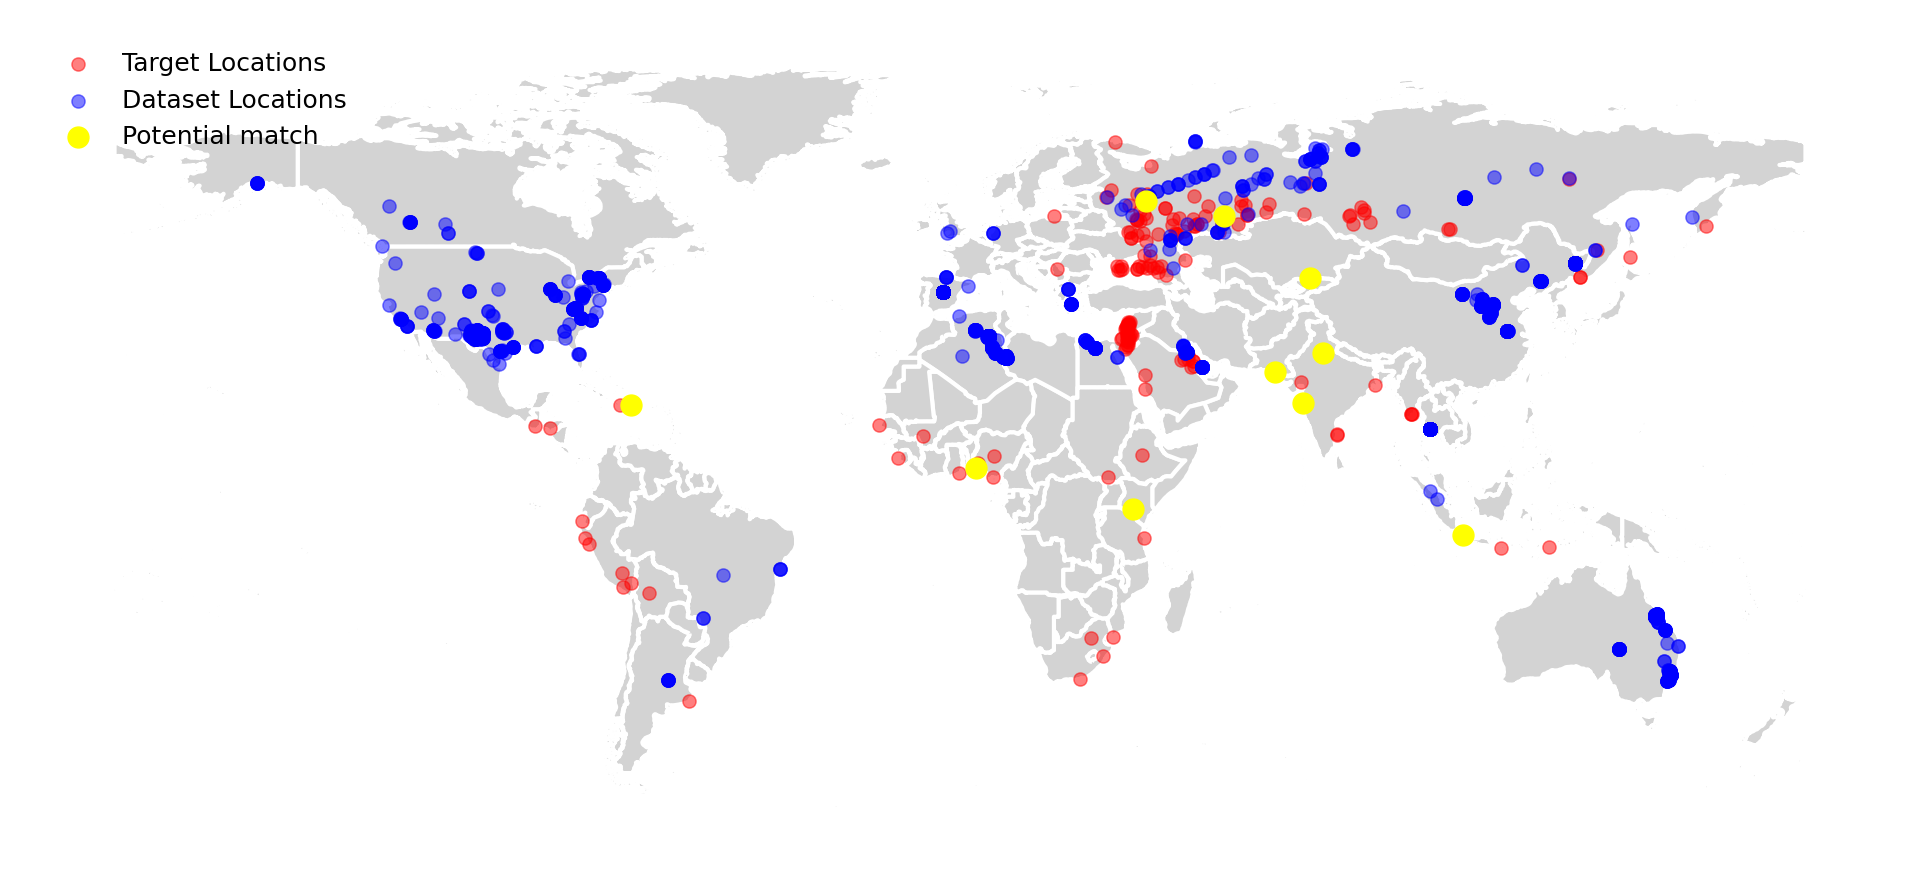

In [26]:
match = test[test.co_string.isin(emsLoc)]
subset = EmGHG2[EmGHG2.co_string.isin(testLoc)]
fig, ax = plt.subplots(figsize = (8,4), facecolor='w', dpi=300)
countries.plot(ax=ax, color = 'lightgrey', edgecolor = 'white')
test.plot(ax=ax, marker = 'o', color= 'r',markersize=10, alpha=0.5, linewidth=0.35, label = 'Target Locations')
EmGHG2.plot(ax=ax, marker = 'o', color= 'b', markersize=10, alpha=0.5, linewidth=0.35, label = 'Dataset Locations')
match.plot(ax=ax, marker = 'o', color= 'yellow', markersize=25, alpha=1, linewidth=0.35, label = 'Potential match')
plt.legend(fontsize = 6, loc ='upper left', frameon=False)

ax.set_axis_off()
# plt.title('UK GHGSat data delivery', fontsize = 8, ha='center',)

In [41]:
match.to_csv('MatchingDumpsites.csv')
subset.to_csv('subset_dumpsites_CR.csv')

In [13]:
def groupData(df):
    data = df.groupby(['year','month'])['success_fr'].sum().reset_index()
    data['n_obs'] = df.groupby(['year','month'])['obsid'].nunique().reset_index().obsid
    data["date"] = [f'{data.year[x]}-{data.month[x]}-01' for x in range(0, len(data))]
    data["date"] = pd.to_datetime(data["date"])
    date = data["date"]
    ems = data["success_fr"]
    obs = data["n_obs"]
    return data, date, ems, obs

def groupDataEm(df):
    data = df.groupby(['year','month'])['rate'].mean().reset_index()
    data['max'] = df.groupby(['year','month'])['rate'].max().reset_index().rate
    data['sum'] = df.groupby(['year','month'])['rate'].sum().reset_index().rate
    data["date"] = [f'{data.year[x]}-{data.month[x]}-01' for x in range(0, len(data))]
    data["date"] = pd.to_datetime(data["date"])
    date   = data["date"]
    emMean = data["rate"]
    emMax  = data["max"]
    emSum  = data["sum"]
    return data, date, emMean, emMax, emSum

In [14]:
def timePlot (data, axis, colour, dLabel, yLabel):
    qurt_year_locator = mdates.MonthLocator(interval=3)
    month_year_formatter = mdates.DateFormatter('%b, %Y') 
    monthly_locator = mdates.MonthLocator()
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(qurt_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.bar(date, data, label = dLabel, color = colour, width=5)
    
    ax.set_ylabel(yLabel)
    
def timePlotEm (data, axis, colour, dLabel, yLabel):
    qurt_year_locator = mdates.MonthLocator(interval=3)
    month_year_formatter = mdates.DateFormatter('%b, %Y') 
    monthly_locator = mdates.MonthLocator()
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(qurt_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.plot(date, data, label = dLabel, color = colour, width=5)
    
    ax.set_ylabel(yLabel)

#### UK Data sector info update

In [15]:
# UK Sector specific info (sector type) provided in a seperate sheet, i have included this too. 
ukSector = pd.read_csv('UK_Data/UK_Observation_sector.csv')
UkData = TotGHG2[TotGHG2.sector2=='UK'].drop(columns = 'datetime')
ukSectorDict = {k: v for k, v in zip(ukSector['Observation ID'], [x.split(',')[0] for x in ukSector.group])}
UkData = UkData.assign(sector = UkData['obsid'].map(ukSectorDict))
ukCoorDict = UkData.groupby('coorid')['sector'].unique().apply(lambda x: x[0]).to_dict()
UkData = UkData.assign(sector2 = UkData['coorid'].map(ukCoorDict))
UkData.to_file('UK_Data_delivery_v1.shp', driver='ESRI Shapefile')

#### Plot timeseries

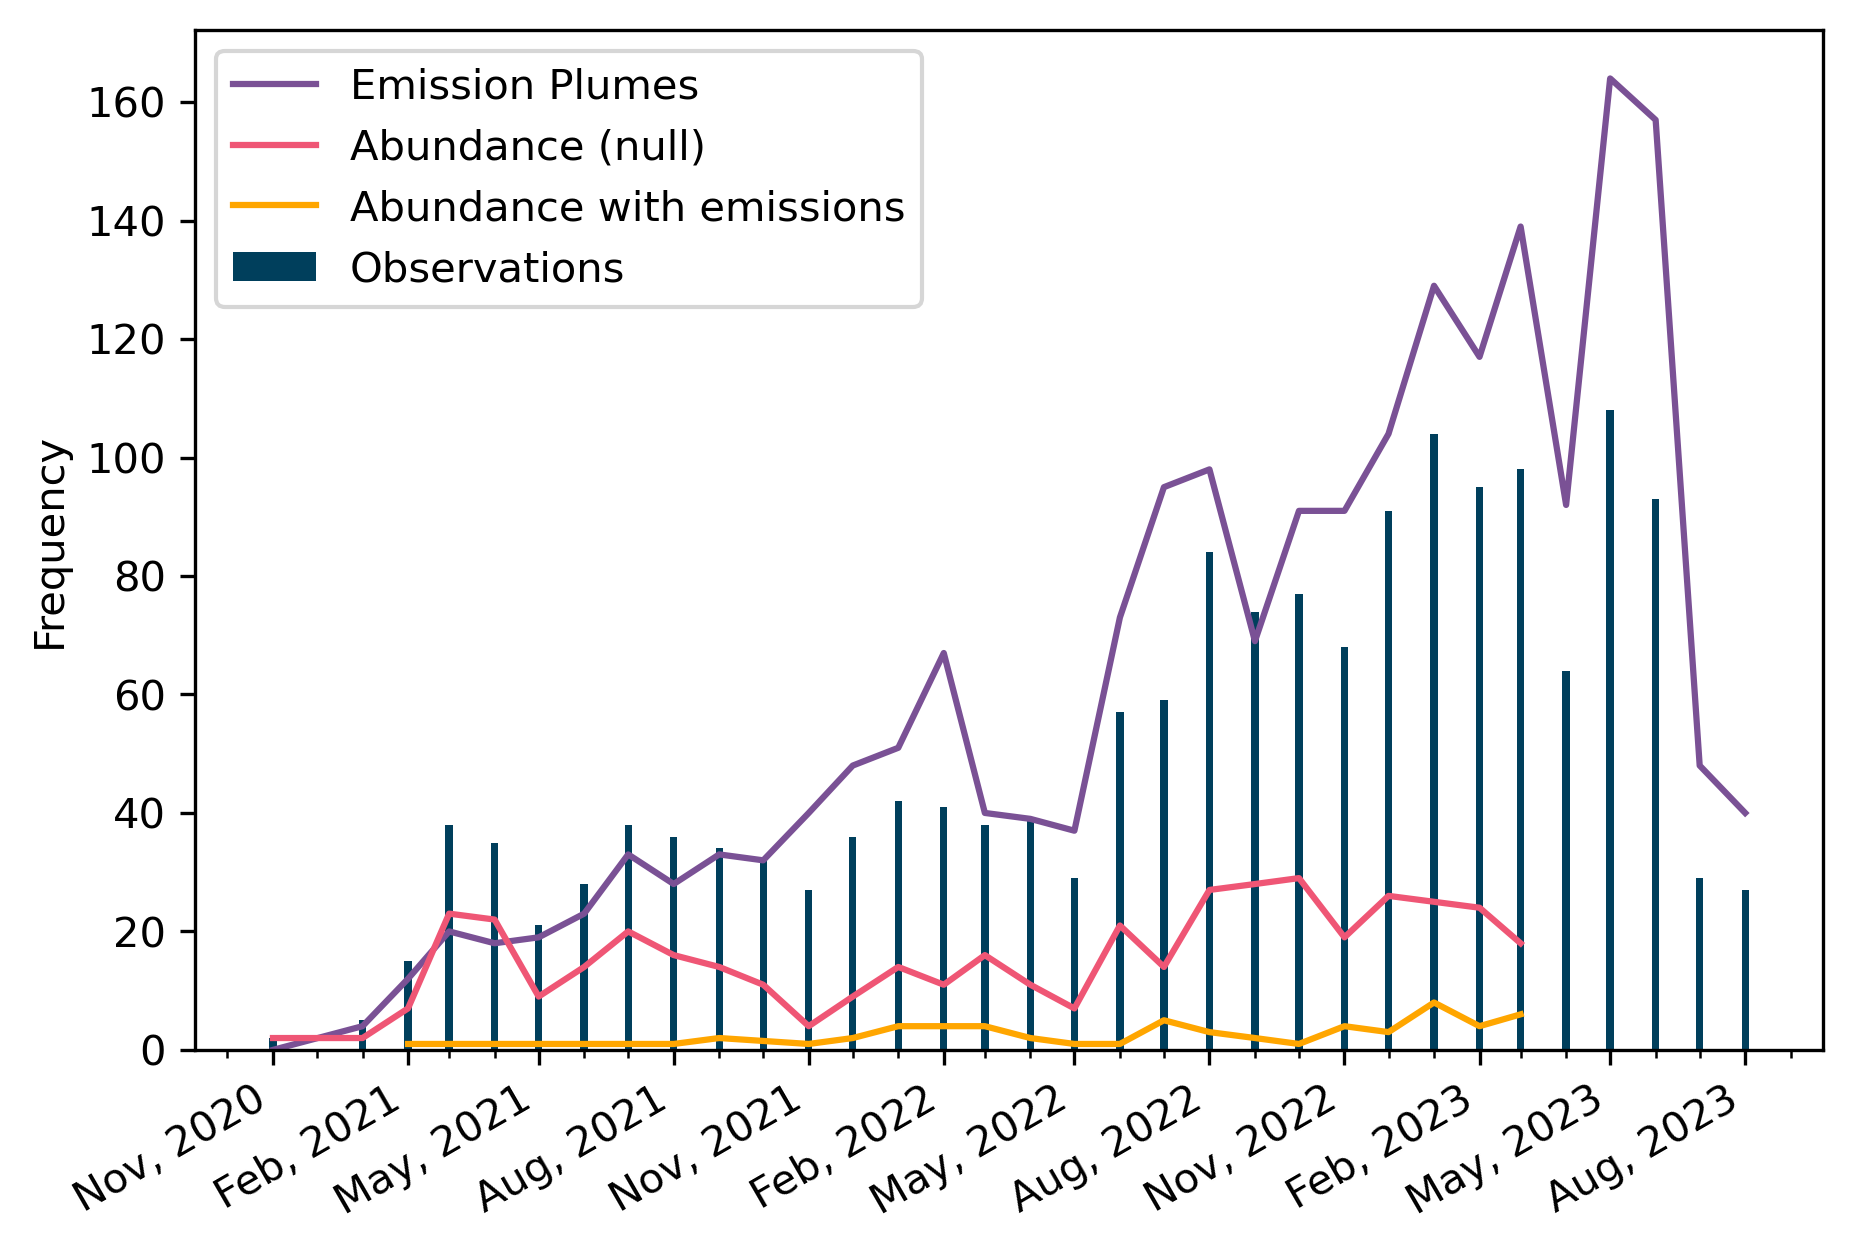

In [16]:
fig, ax = plt.subplots(figsize=(7,5), dpi=300)

df, date, ems, obs = groupData(TotGHG2)
ax.plot(date,  ems, color='#7a5195',label = 'Emission Plumes')

timePlot (obs, ax, '#003f5c', 'Observations', 'Frequency')

df2, date, ems, obs2 = groupData(AbGHG2[AbGHG2.success_fr==0])
# Increase the timestamp by 15 days
# x2 = [x + relativedelta(days=7) for x in date]
# ax.bar(x2, obs, color= '#73ACF9', alpha = 1, label = 'Abundance',width=5)
ax.plot(date, obs2, color= '#ef5675', label = 'Abundance (null)')
# ax.set_title('Number of Satellite Observations and Emission Detections')

# timePlot (obs, ax, 'b', 'Emissions', 'Frequency')

df, date, ems, obs = groupData(AbGHG2[AbGHG2.success_fr>0])
ax.plot(date, obs, color= '#ffa600', label = 'Abundance with emissions')
# timePlot (obs, ax, 'g', 'Emissions', 'Frequency')


ax.legend()
# 
fig.autofmt_xdate()

#### Plot timeseries by sector

In [209]:
# Plot locations per continent
data = dfEms.groupby('continent')['coorid'].count().reset_index()
plt.bar(data.continent, data.coorid)
plt.xticks(rotation = 45, fontsize=14)
plt.ylabel('Number of locations', fontsize = 14)
plt.close()
# Plot number of abundnace data per continent
data = dfAbs.groupby('continent')['n_imgs'].sum().reset_index()
plt.bar(data.continent, data.n_imgs)
plt.xticks(rotation = 45, fontsize=14)
plt.ylabel('Number of Abundance data', fontsize = 14)
plt.close()
# Plot number of emissions per continent
data = dfEms.groupby('continent')['success_fr'].sum().reset_index()
plt.bar(data.continent, data['success_fr'])
plt.xticks(rotation = 45, fontsize=14)
plt.ylabel('Number of Emissions', fontsize = 14)
plt.close()

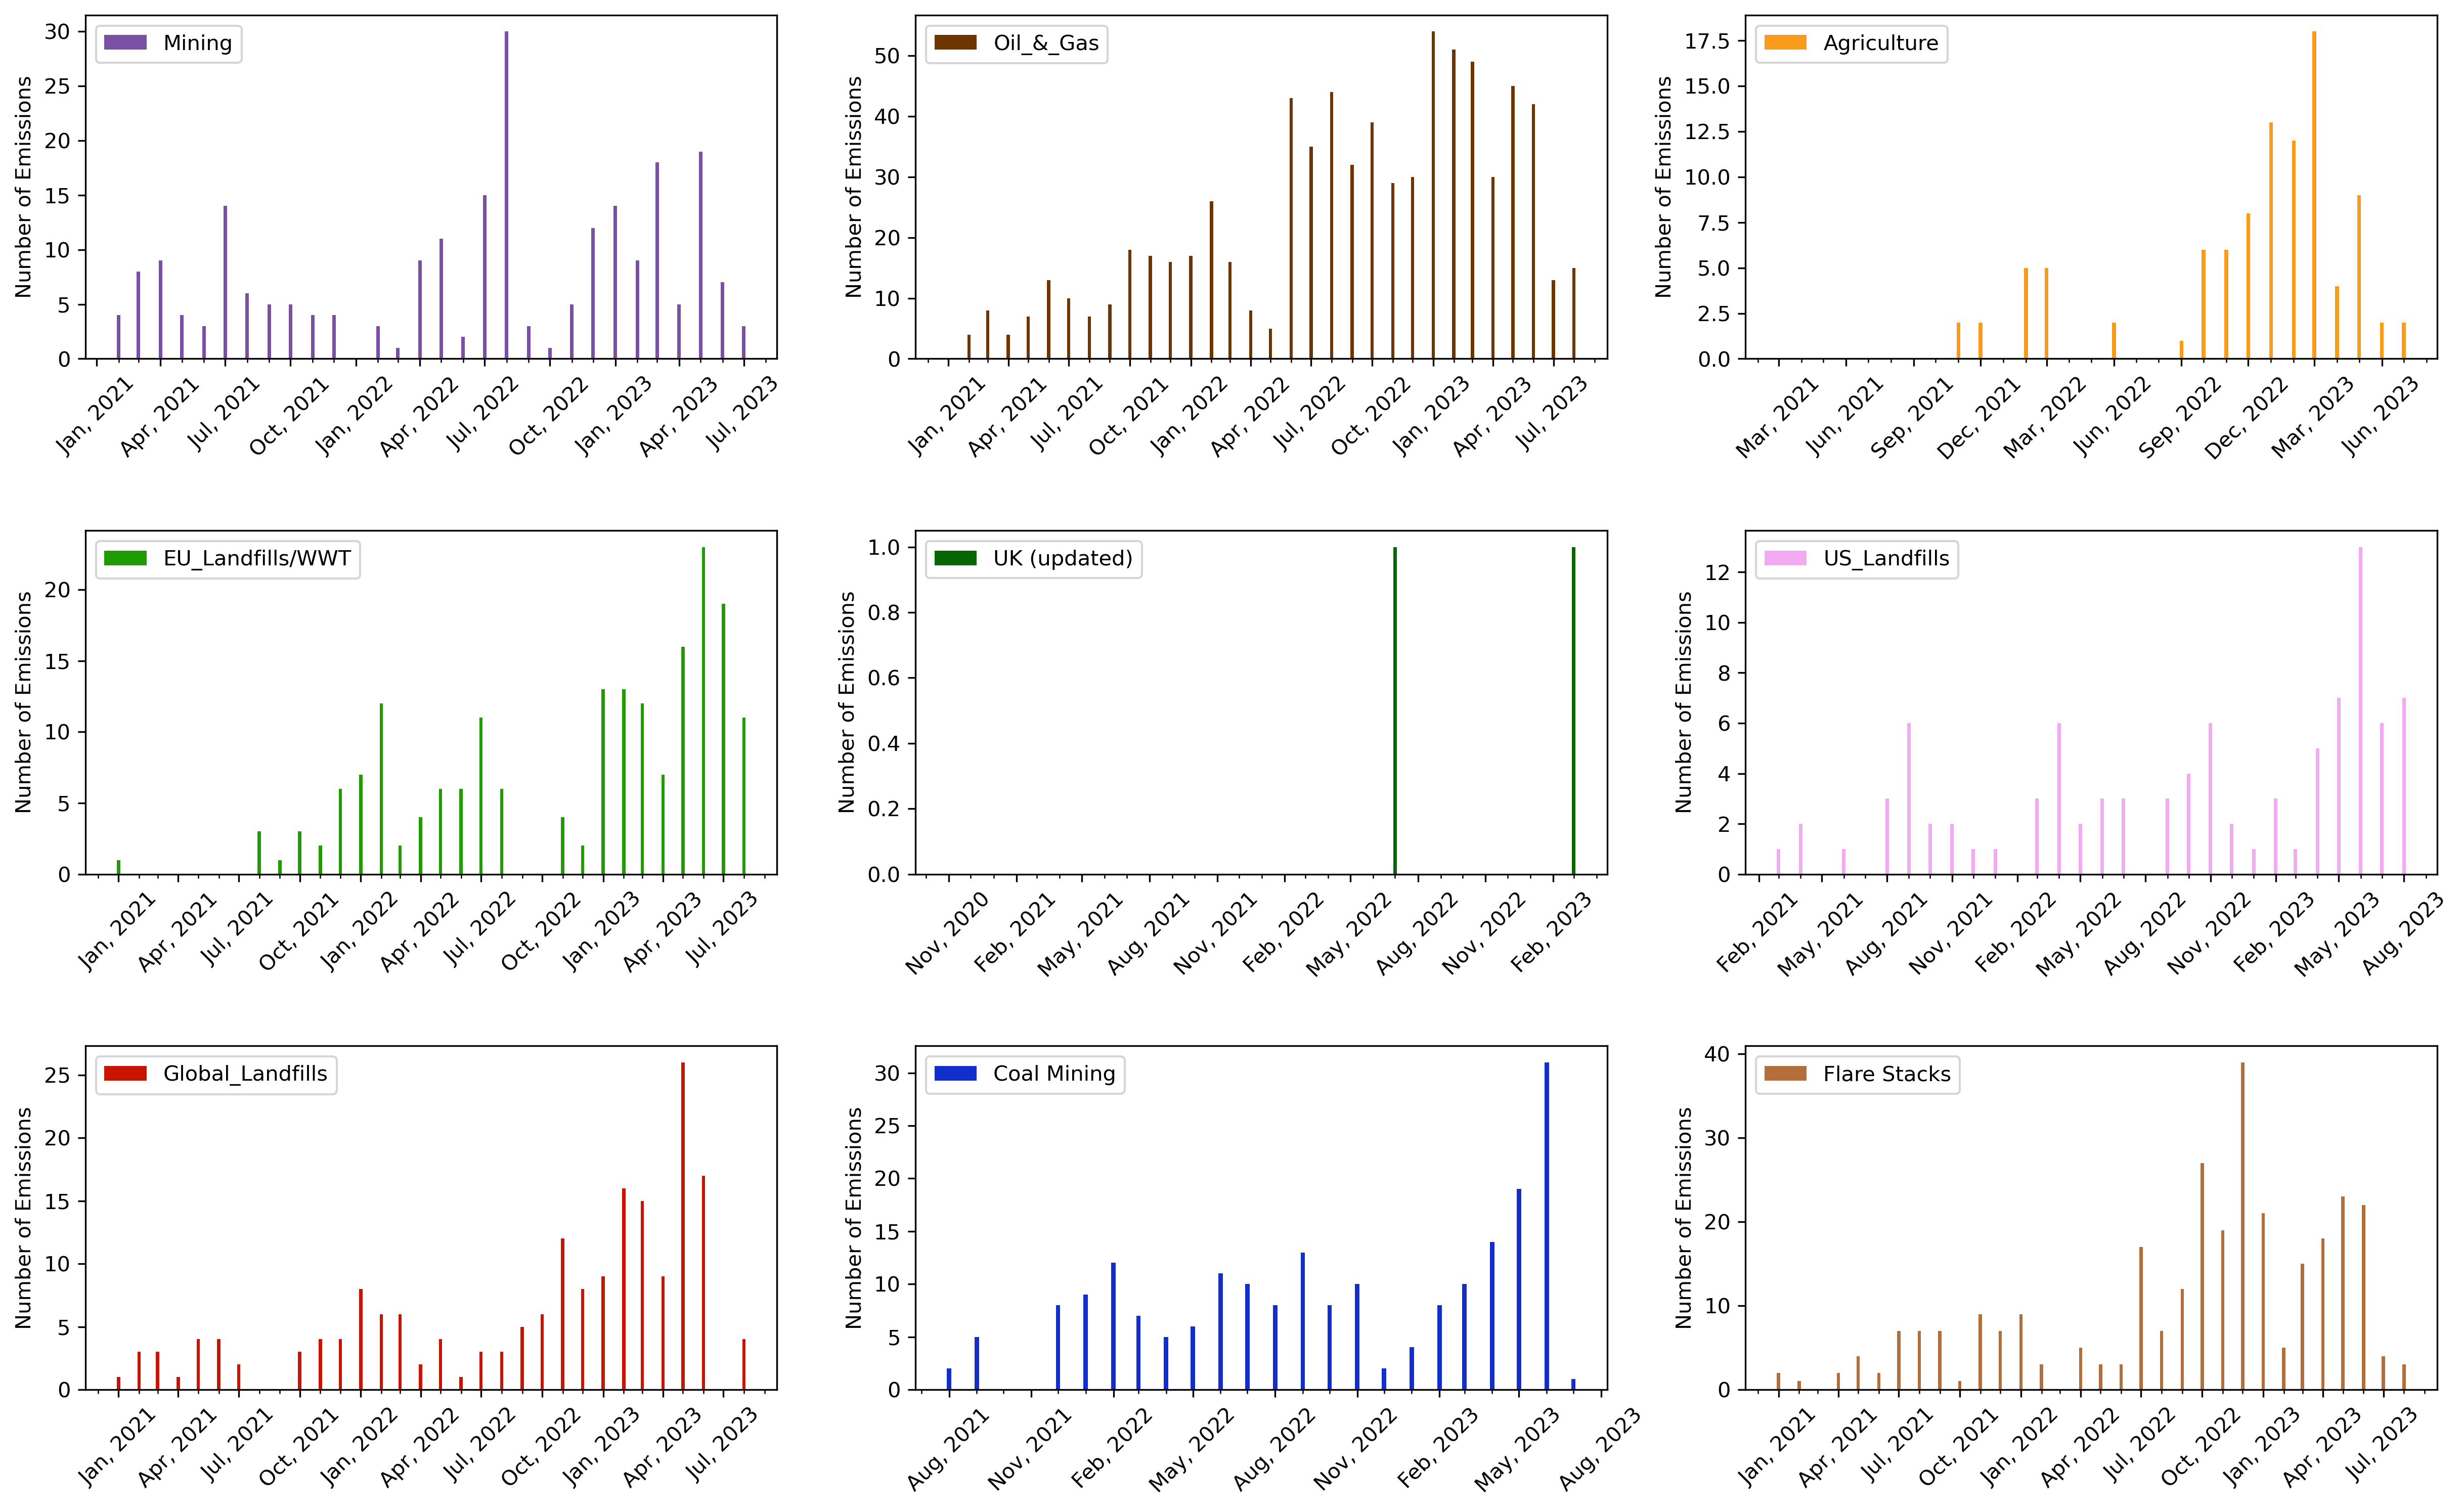

In [412]:
# Plot number of emissions

# Create your figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(20,12), dpi=300)
exclude = ['EU_Landfils', 'Abattoirs']

for i, ax in enumerate(axes.flatten()):
    subs  = [x for x in TotGHG2.group.unique() if x not in exclude]
    if i < len(subs):
        df, date, ems, obs = groupData(TotGHG2[TotGHG2.group == subs[i]])
    
        timePlot (ems, ax, colDict[subs[i]], subs[i], 'Number of Emissions')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.legend(loc ='upper left')

#         fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Adjust the spacing as needed

#### Plot timeseries by continent

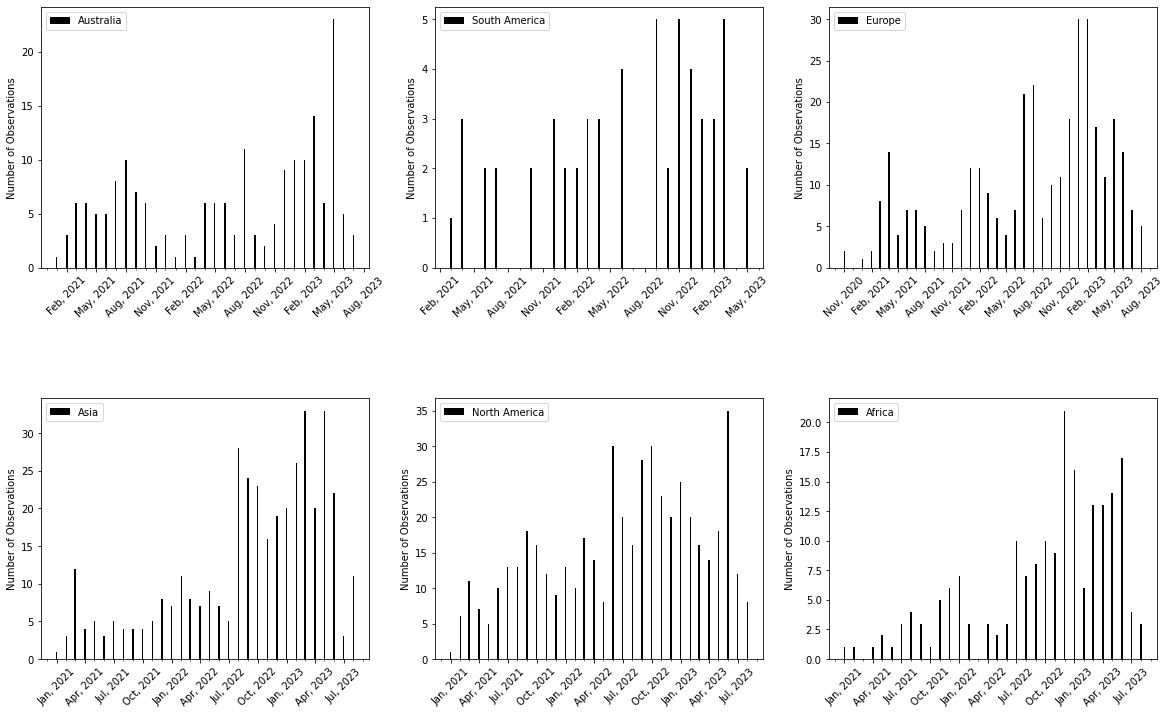

In [413]:
# Plot number of observations

# Create your figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(20,12))
exclude = ['EU_Landfils', 'Abattoirs']

for i, ax in enumerate(axes.flatten()):
    subs  = [x for x in TotGHG2.continent.unique() if x not in exclude]
    if i < len(subs):
        df, date, ems, obs = groupData(TotGHG2[TotGHG2.continent == subs[i]])
    
        timePlot (obs, ax, 'k', subs[i], 'Number of Observations')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.legend(loc ='upper left')

#         fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Adjust the spacing as needed

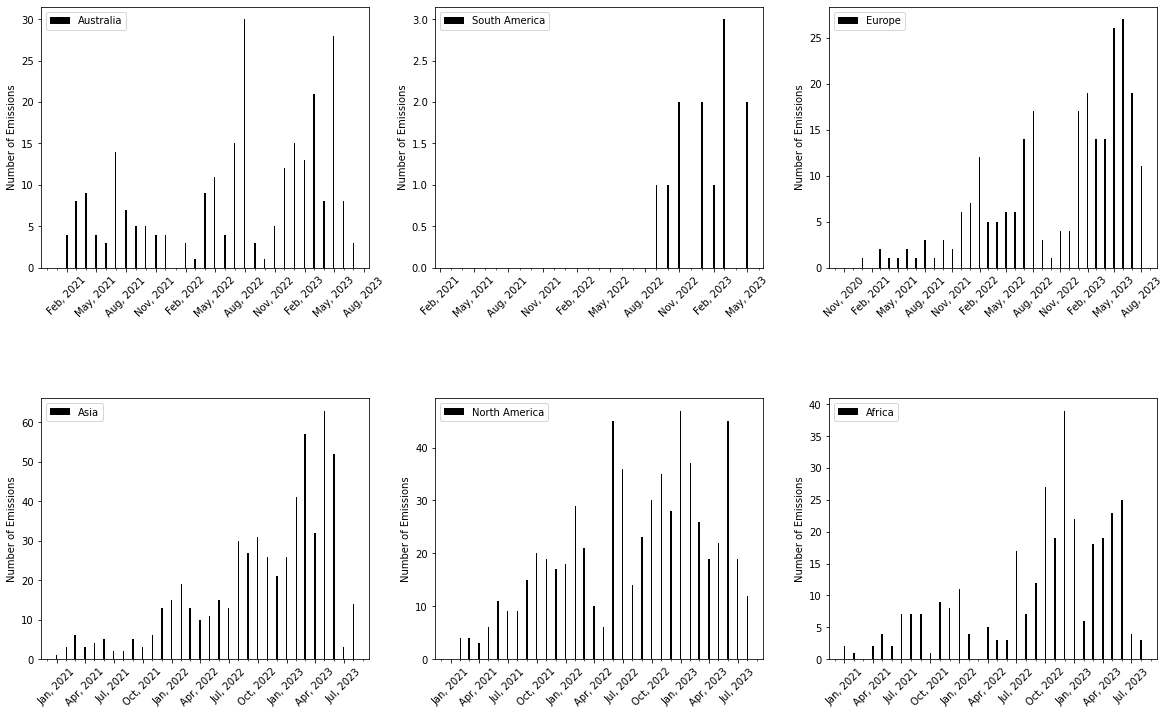

In [414]:
# Plot number of emissions

# Create your figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(20,12))
exclude = ['EU_Landfils', 'Abattoirs']

for i, ax in enumerate(axes.flatten()):
    subs  = [x for x in TotGHG2.continent.unique() if x not in exclude]
    if i < len(subs):
        df, date, ems, obs = groupData(TotGHG2[TotGHG2.continent == subs[i]])
    
        timePlot (ems, ax, 'k', subs[i], 'Number of Emissions')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.legend(loc ='upper left')

#         fig.autofmt_xdate()
plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Adjust the spacing as needed

#### Save abundence and emission data seperately (full df / row = observation)

In [ ]:
dfGHGtot = dfGHGtot.assign(datetime = dfGHGtot['datetime'].astype(str))
dfGHGtot.to_file(folder + 'GHGSat_emissions_M2.shp', driver='ESRI Shapefile')
dfGHGtot.to_csv(folder + 'GHGSat_emissions_M2.csv')

#### Plot data

#### Plot Specific regions

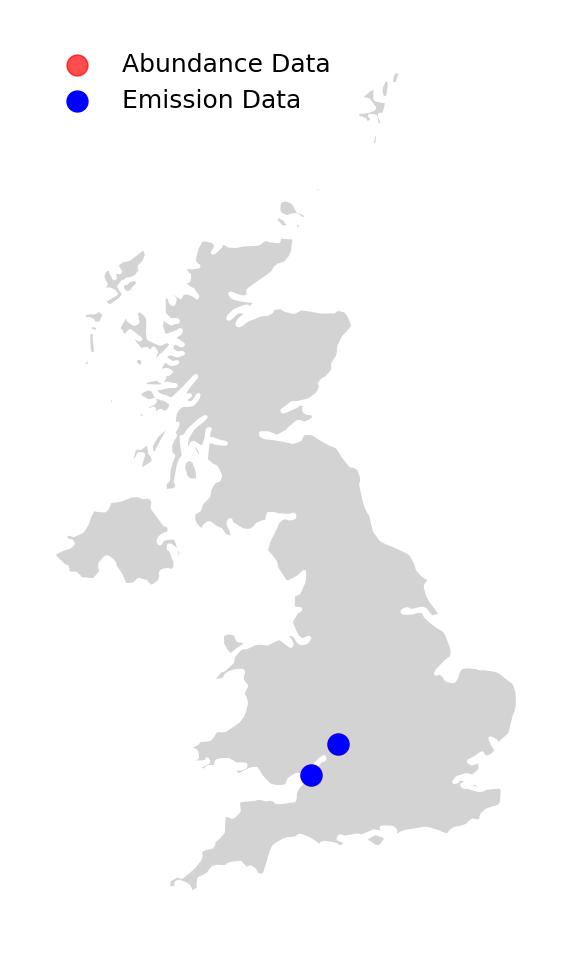

In [296]:
country = countries[countries['CNTRY_NAME'] == 'United Kingdom']
data  = dfEms[dfEms.cntry_name == 'United Kingdom']
obs = data[data['success_fr'] > 0]

fig, ax = plt.subplots(figsize = (8,4), facecolor='w', dpi=300)
country.plot(ax=ax, color = 'lightgrey', edgecolor = 'white')
data.plot(ax=ax, marker = 'o', color= 'r',markersize=25, alpha=0.7, linewidth=0.35, label = 'Abundance Data')
obs.plot(ax=ax, marker = 'o', color= 'b', markersize=25, alpha=1, linewidth=0.35, label = 'Emission Data')
plt.legend(fontsize = 6, loc ='upper left', frameon=False)

ax.set_axis_off()
# plt.title('UK GHGSat data delivery', fontsize = 8, ha='center',)
plt.savefig('Figures/UK_data_type.png', dpi=300)

In [ ]:
country = countries[countries['CNTRY_NAME'] == 'United Kingdom']
data  = TotGHG2[TotGHG2.cntry_name == 'United Kingdom']
obs = data[data['success_fr'] > 0]

fig, ax = plt.subplots(figsize = (8,4), facecolor='w', dpi=300)
country.plot(ax=ax, color = 'lightgrey', edgecolor = 'white')
data.plot(ax=ax, marker = 'o', color= '#8D05FE',markersize=data['n_imgs']*10, alpha=0.7, edgecolors ='purple', linewidth=0.5, label = 'Observation Locations')

plt.legend(fontsize = 6, loc ='upper left')

# ax.set_axis_off()
plt.title('UK GHGSat data delivery', fontsize = 8, ha='center',)
plt.savefig('Figures/UK_data_type.png', dpi=300)

In [ ]:
# UkCol = {'Power Generation': '#B0120D', 'Waste Management': '#33B616',
#        'Mining': '#5C16B6', 'Oil & Gas': '#B0520D'}

# data = data.assign(sector2 = data['coorid'].map(ukCoorDict)) 
# data = data[~data.sector2.isna()]
# data = data.assign(UKcol = data.sector2.map(UkCol))
# data = data.assign(group = [x.split(',')[0] for x in data.sector2])
# data.to_file('UK_Data_locations_v1.shp', driver='ESRI Shapefile')

# leg = [Line2D([0], [0], marker='o', color='w', label=x.split(',')[0], markerfacecolor=UkCol[x], markersize=8) for x in UkCol]


# fig, ax = plt.subplots(figsize = (8,4), facecolor='w', dpi=300)
# country.plot(ax=ax, color = 'lightgrey', edgecolor = 'white')
# data.plot(ax=ax, marker = 'o', color= data.UKcol, markersize=data['n_imgs']*10, alpha=0.7, edgecolors =data.UKcol, linewidth=0.5)

# plt.legend(handles=leg, loc='upper left', fontsize = 5, labelspacing=0.8, frameon=False)

# ax.set_axis_off()
# # plt.title('UK GHGSat data delivery', fontsize = 8, ha='center',)
# plt.savefig('Figures/UK_sector_type.png', dpi=300)

In [ ]:
data[data.success_fr == 0].n_imgs.sum()

In [ ]:
data[data.sector2.isna()]


In [ ]:
sectorImgs = data.groupby('sector2')['n_imgs'].sum().to_dict()
plt.pie(sectorImgs.values(),autopct='%1.1f%%', pctdistance=1.15, colors=[UkCol[x] for x in sectorImgs.keys()])#, labels=sectorImgs.values())
plt.title('Proportion of images per sector')
legendLabs = [x.split(',')[0] for x in sectorImgs.keys()]
plt.legend(legendLabs,bbox_to_anchor=(1.1, 1))

In [ ]:
sectorImgs = data.groupby('sector2')['coorid'].nunique().to_dict()
plt.pie(sectorImgs.values(), colors=[UkCol[x] for x in sectorImgs.keys()], labels=sectorImgs.values())
plt.title('Number of UK locations per sector')
legendLabs = [x.split(',')[0] for x in sectorImgs.keys()]
# plt.legend(legendLabs,bbox_to_anchor=(1.1, 1))

In [ ]:
sum(data.groupby('sector2')['coorid'].nunique())

In [ ]:
fig, ax = plt.subplots(figsize=(7,5), facecolor='w', dpi=300)

df, date, ems, obs = groupData(dfGHGtot[dfGHGtot.cntry_name == 'United Kingdom'])

timePlot (obs, ax, 'red', 'Observations', 'Number of data')
x2 = [x - relativedelta(days=15) for x in date]
ax.bar(x2, ems, color= 'b', label = 'Emissions',width=4)
ax.legend()
# 
fig.autofmt_xdate()

#### Plot global data

In [17]:
def globalPlot(data, title, legend1, markertype, addleg, saveFig, scale):
    
    fig, ax = plt.subplots(figsize = (18,9), facecolor='w', dpi=300)
    countries.plot(ax=ax, color = 'lightgrey', edgecolor = 'white')
    data.plot(ax=ax, marker = 'o', markersize=markertype, color = data.color, alpha=0.7, linewidth=0.35)

    leg1 = plt.legend(handles=legend1, loc='lower left', fontsize = 12, labelspacing=0.8, frameon=False)
    # Add the first legend to the current axes
    plt.gca().add_artist(leg1)
    
    if addleg == True:
        legend2 = [(Line2D([0], [0], marker='o', color='w', label=f'Min: {data[scale].min()}', markerfacecolor='grey', markersize=10)),
                (Line2D([0], [0], marker='o', color='w', label=f'Max: {data[scale].max()}', markerfacecolor='grey', markersize=18))]
        # Create the second legend with handles and labels
        leg2 = plt.legend(handles = legend2, loc='upper left', fontsize = 12, labelspacing=0.8, frameon=False)

    ax.set_axis_off()
    plt.title(title, fontsize = 16, ha='center',)
    if saveFig == True:
        plt.savefig(f'Figures/{title}.png', dpi=300)
    

Text(0.5, 1.0, 'Selected subset of GHGSat data')

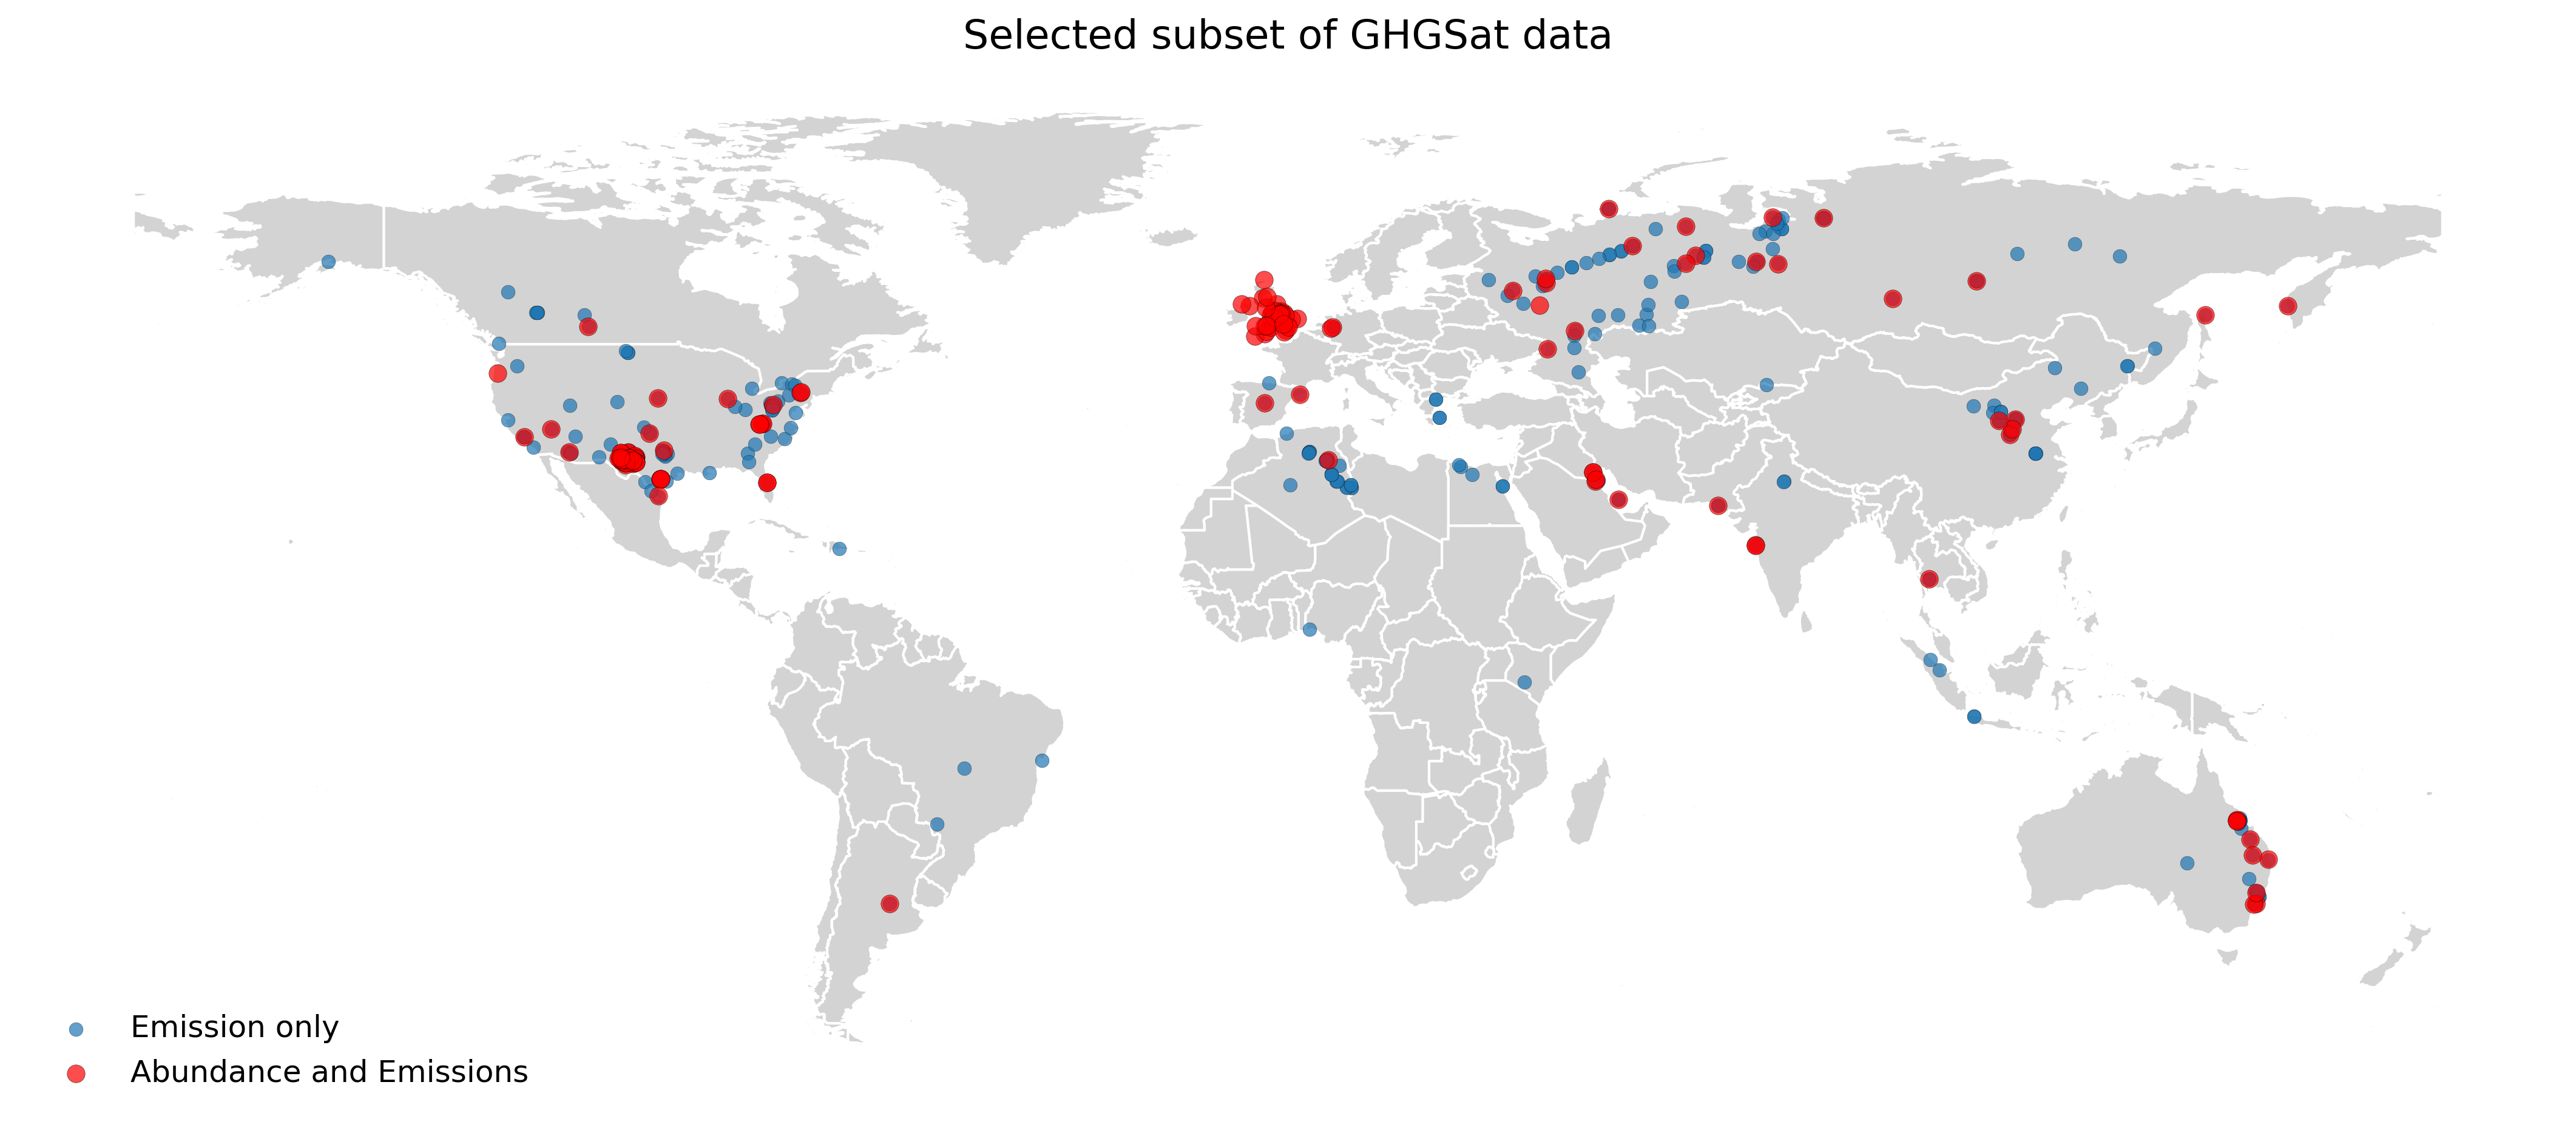

In [37]:
nullsData = dfAbs[(dfAbs.success_fr==0) & (dfAbs.cntry_name=='United Kingdom')]

# Plot emission and abundance data 
fig, ax = plt.subplots(figsize = (18,9), facecolor='w', dpi=300)
countries.plot(ax=ax, color = 'lightgrey', edgecolor = 'white')
dfEms.plot(ax=ax, marker = 'o', markersize=30, alpha=0.7, linewidth=0.10, edgecolors = 'k', label = 'Emission only')
dfAbs.plot(ax=ax, marker = 'o', color ='r', markersize=50, alpha=0.7, linewidth=0.15, edgecolors = 'k', label = 'Abundance and Emissions')

# dfAbs[dfAbs.success_fr>0].plot(ax=ax, marker = 'o', color ='r', markersize=30, alpha=1, linewidth=0.15, edgecolors = 'k', label = 'Abundance with Emissions')
# dfAbs[dfAbs.success_fr==0].plot(ax=ax, marker = 'o', color ='yellow', markersize=30, alpha=1, linewidth=0.15, edgecolors = 'k', label = 'Abundance (null) and Emissions')
# nullsData.plot(ax=ax, marker = 'o', color ='green', markersize=30, alpha=1, linewidth=0.15, edgecolors = 'k', label = 'Abundance (null) only')
plt.legend(fontsize = 12, loc ='lower left', frameon=False)
# Remove the legend border

ax.set_axis_off()
plt.title('Selected subset of GHGSat data', fontsize = 16, ha='center',)
# plt.savefig('Figures/GHGSat data delivery.png', dpi=300)

#### Plot all data by sector

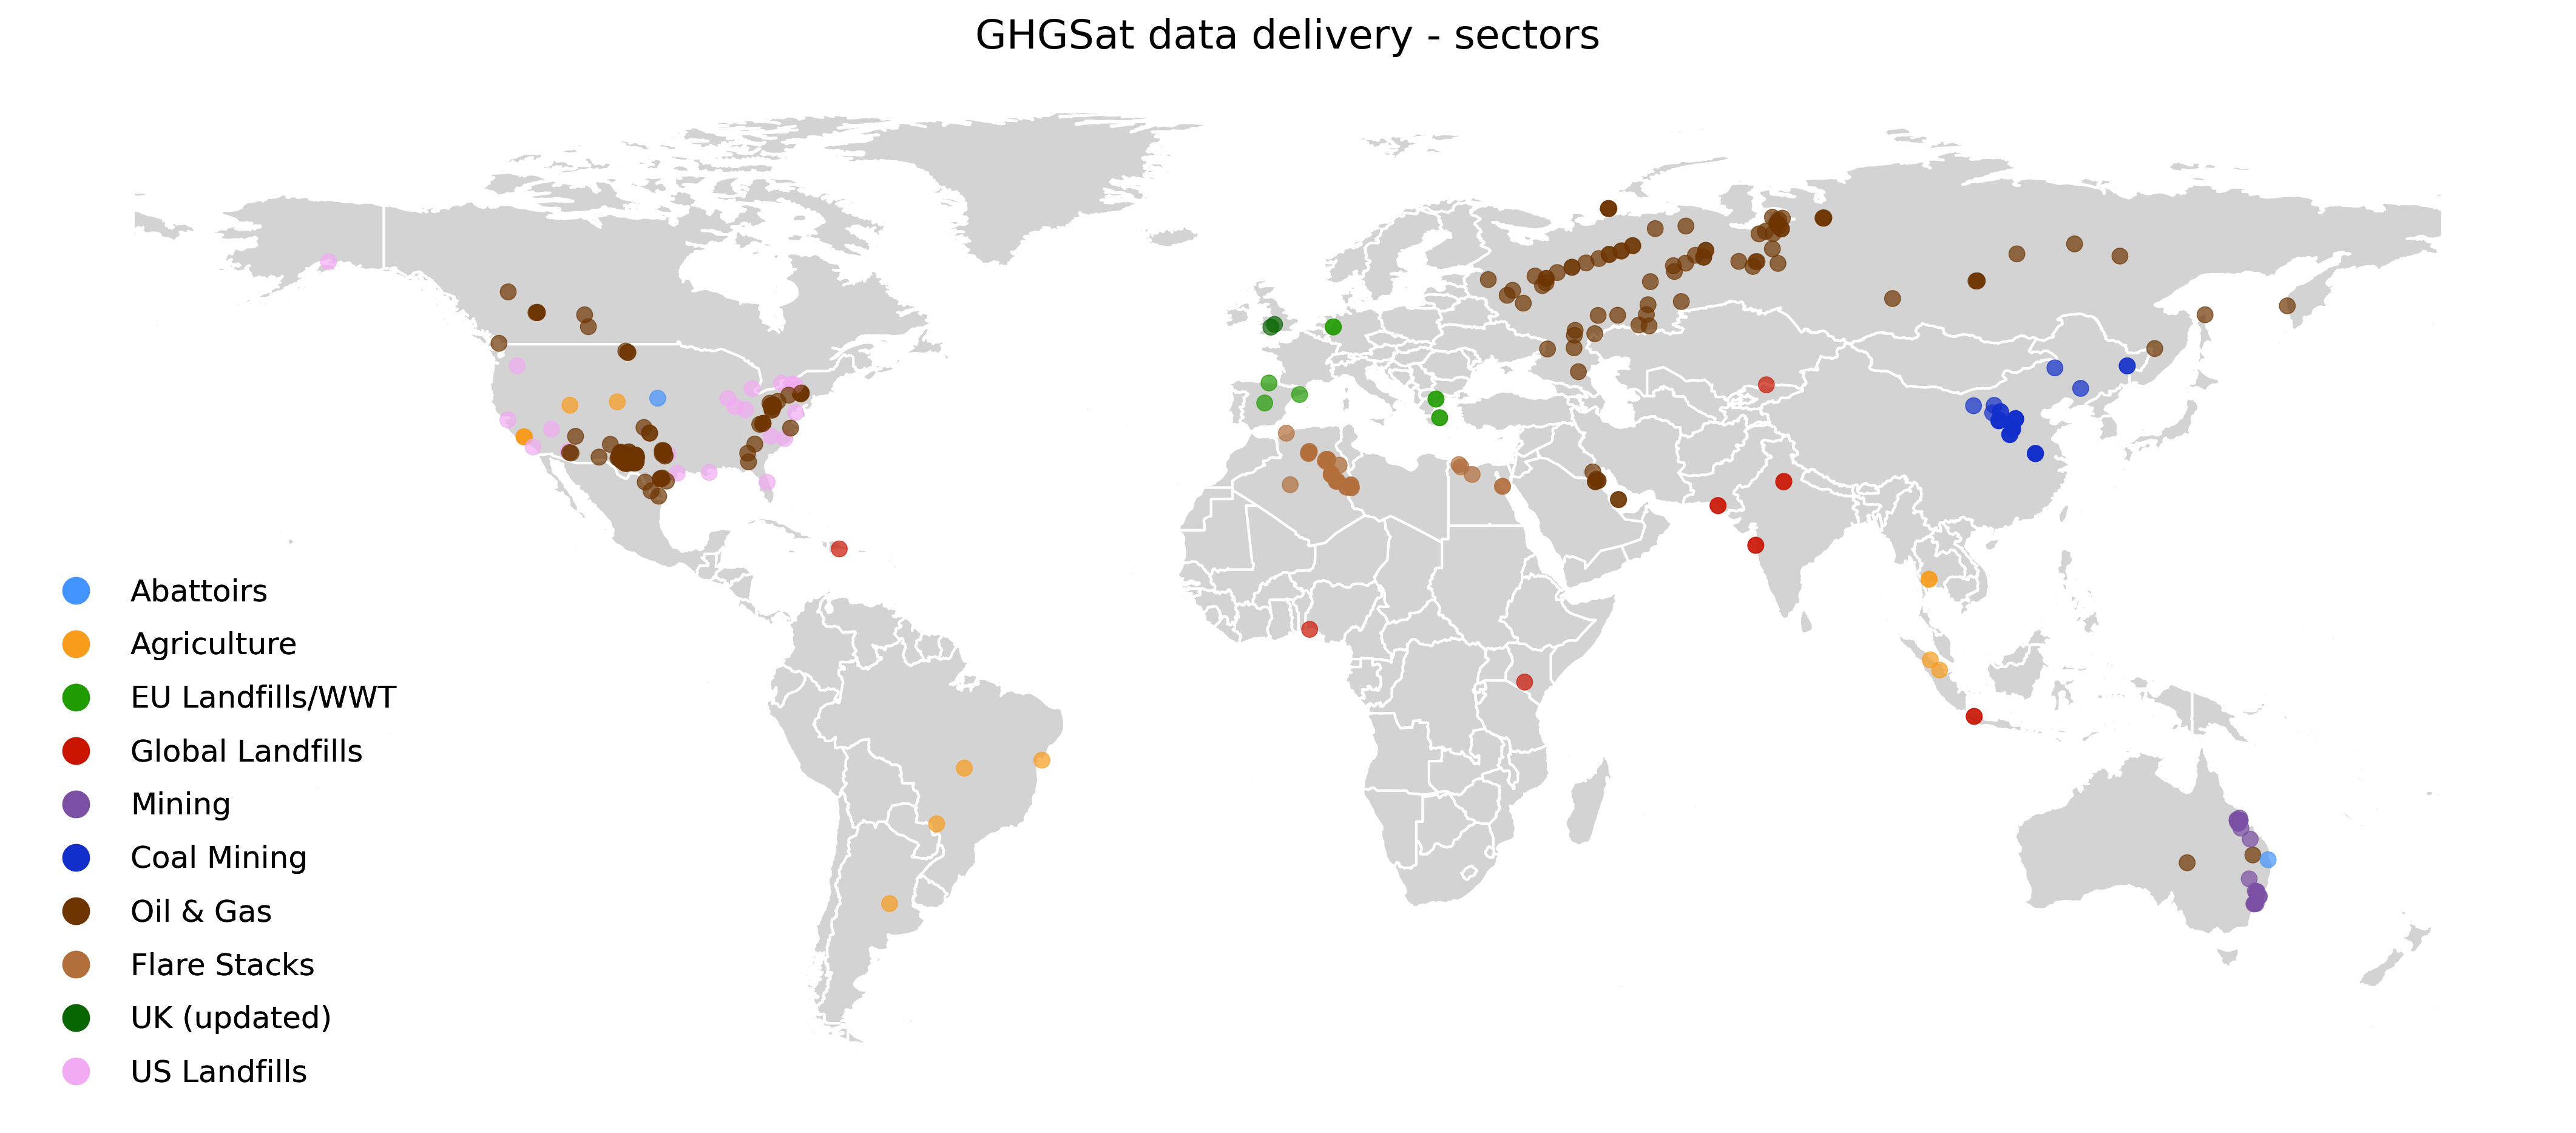

In [39]:
leg = [Line2D([0], [0], marker='o', color='w', label=x.replace('_', ' '), markerfacecolor=colDict[x], markersize=12) for x in colDict]

# PLot just the locations
globalPlot(dfEms, 'GHGSat data delivery - sectors', leg, 40, False, True, False)

#### Emission data analysis

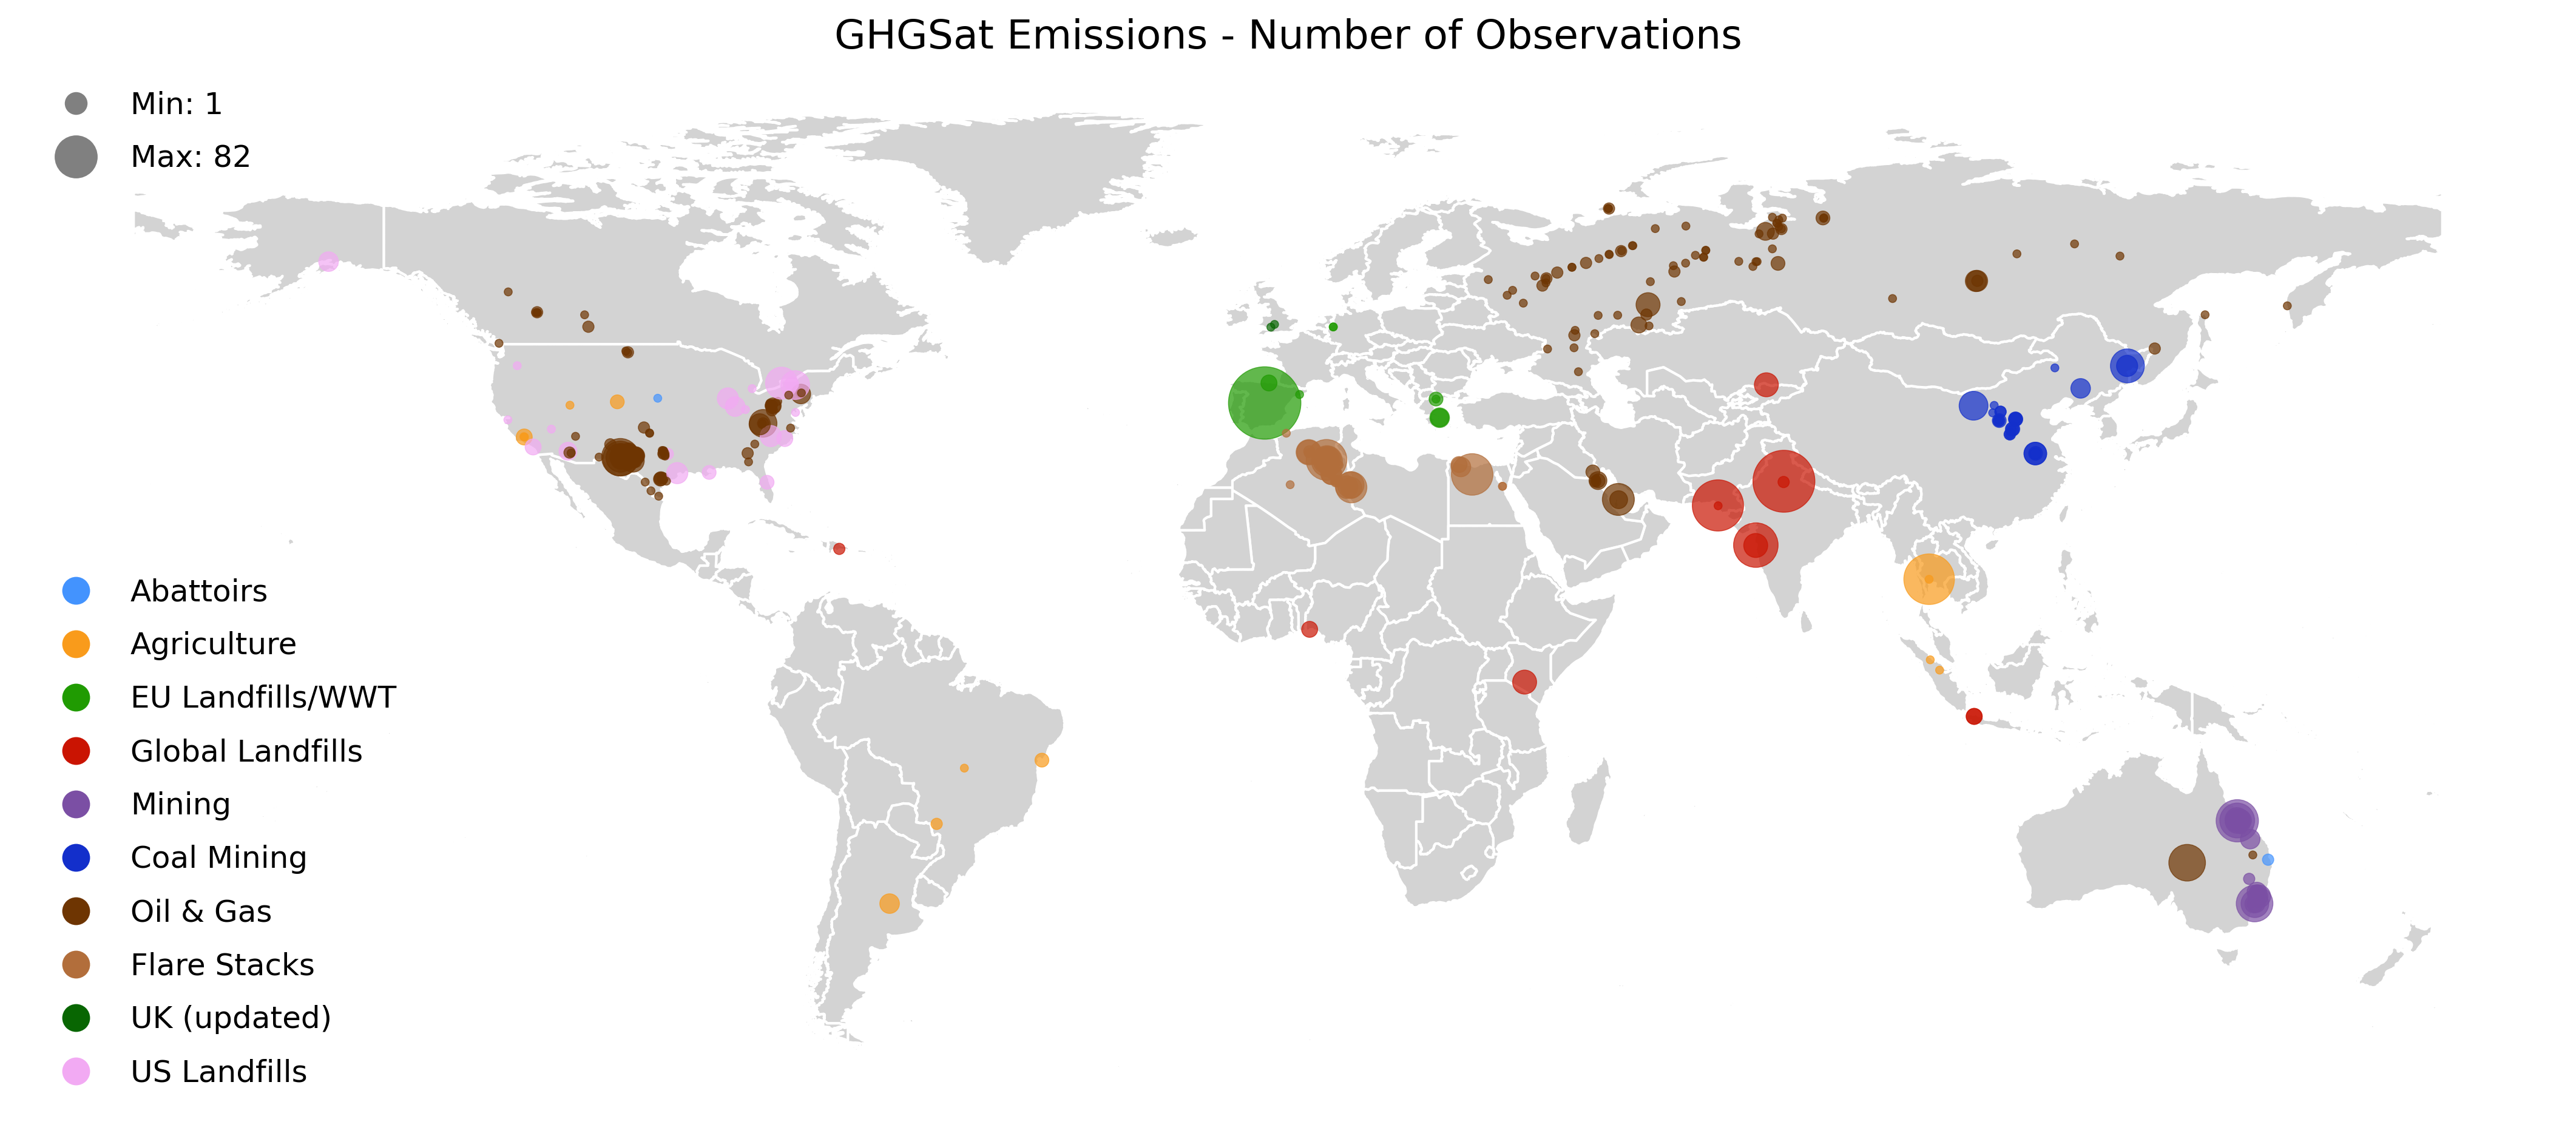

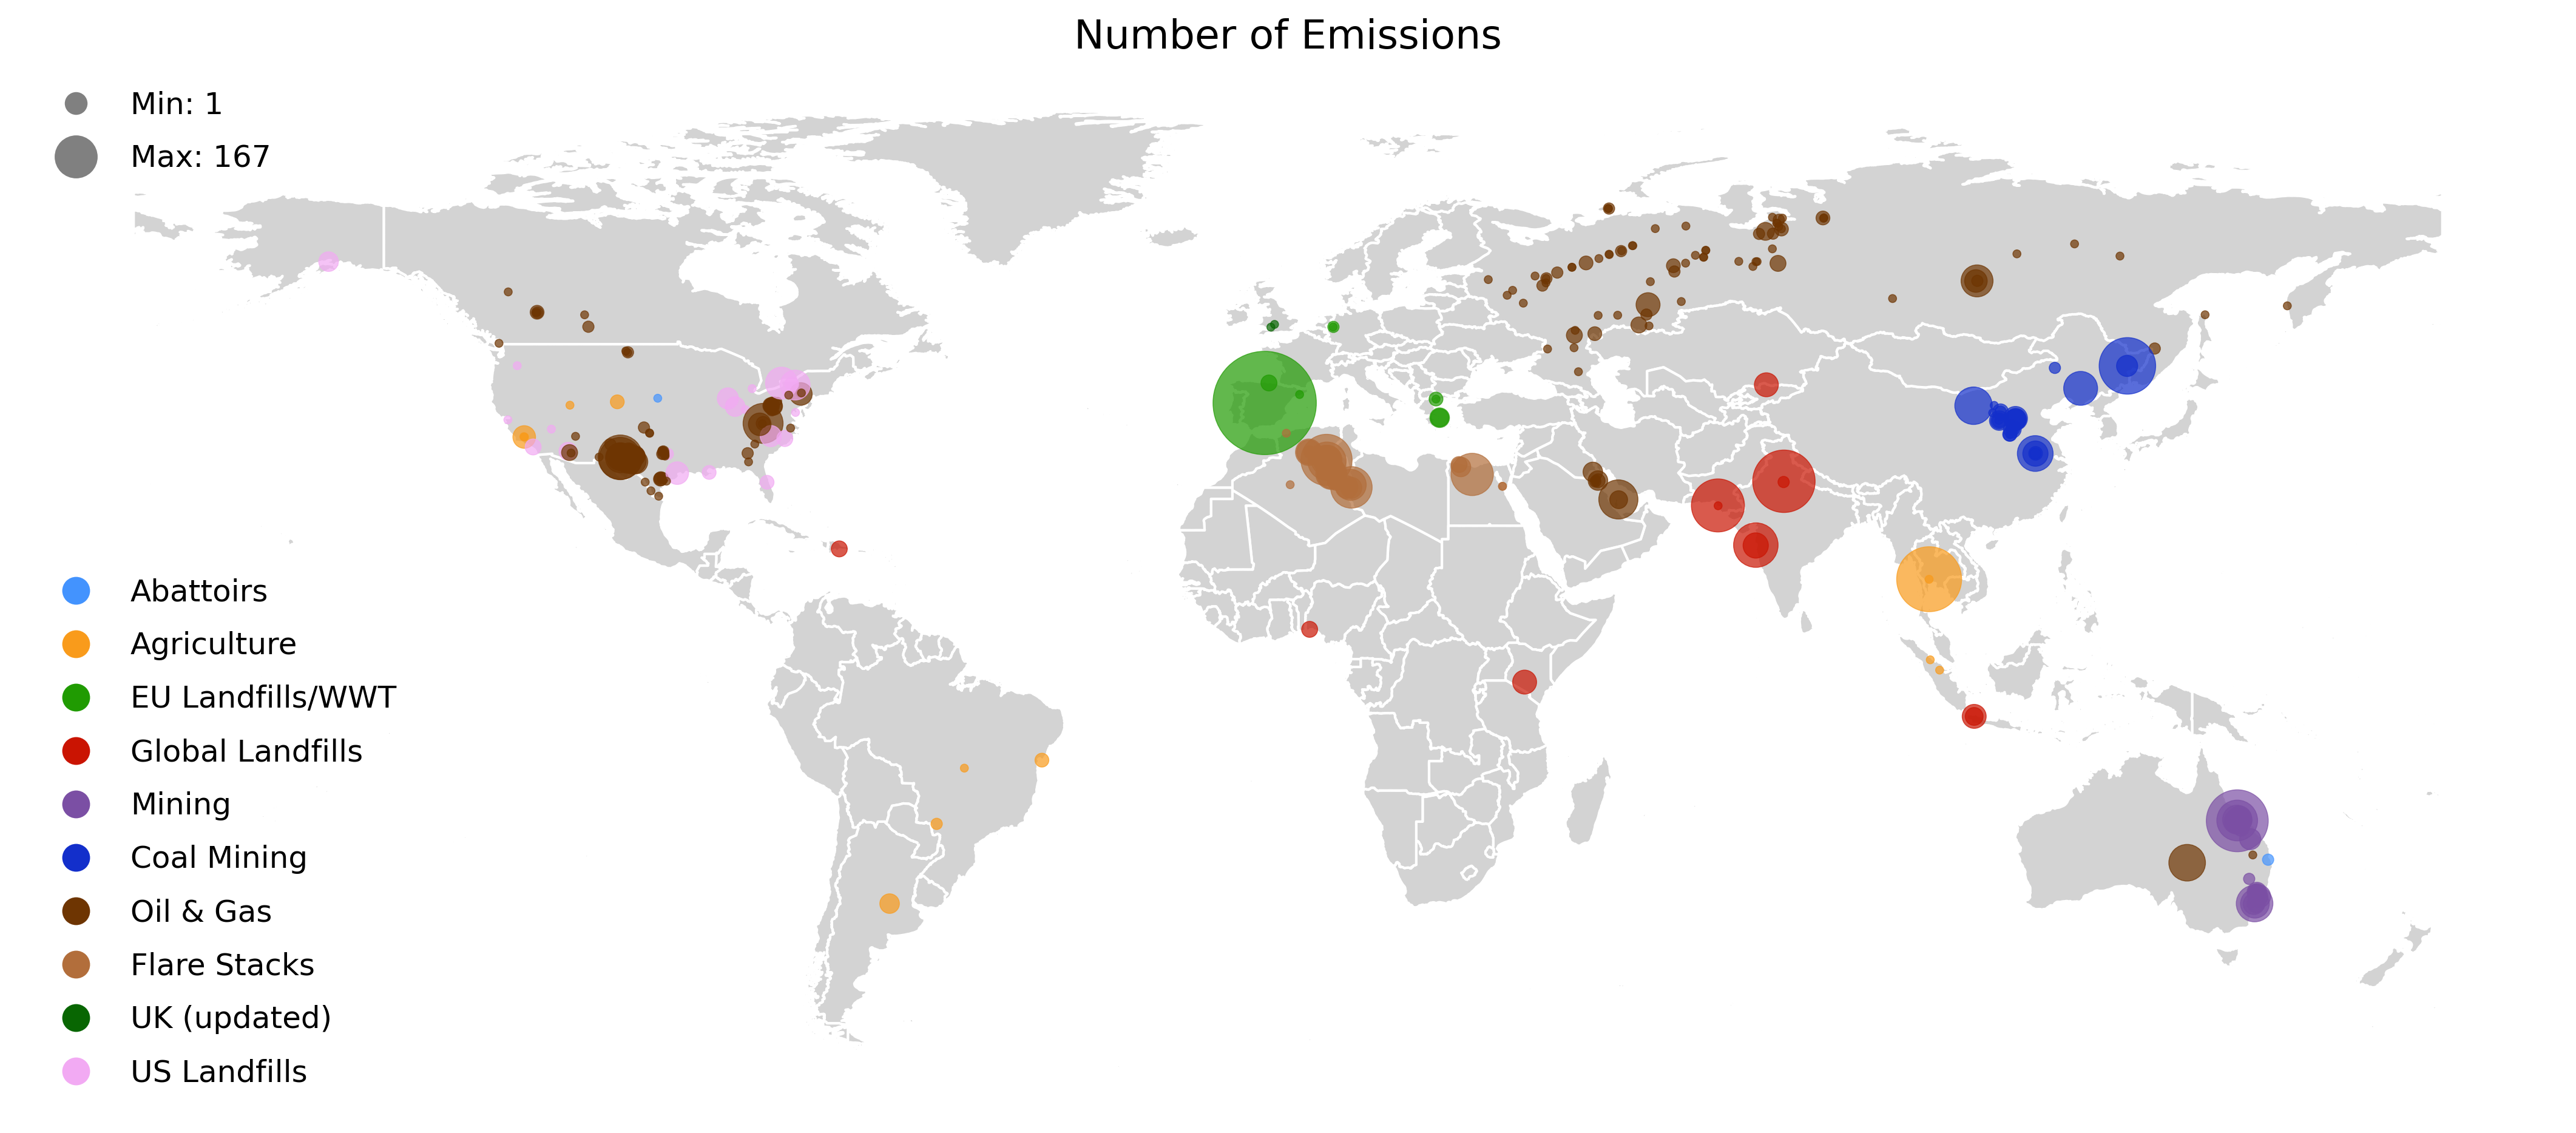

In [40]:
# PLot just the locations with number of images
globalPlot(dfEms, 'GHGSat Emissions - Number of Observations', leg, dfEms['n_imgs']*10, True, False,'n_imgs' )

# PLot just the locations with number of images
globalPlot(dfEms, 'Number of Emissions', leg, dfEms['success_fr']*10, True, False,'success_fr' )

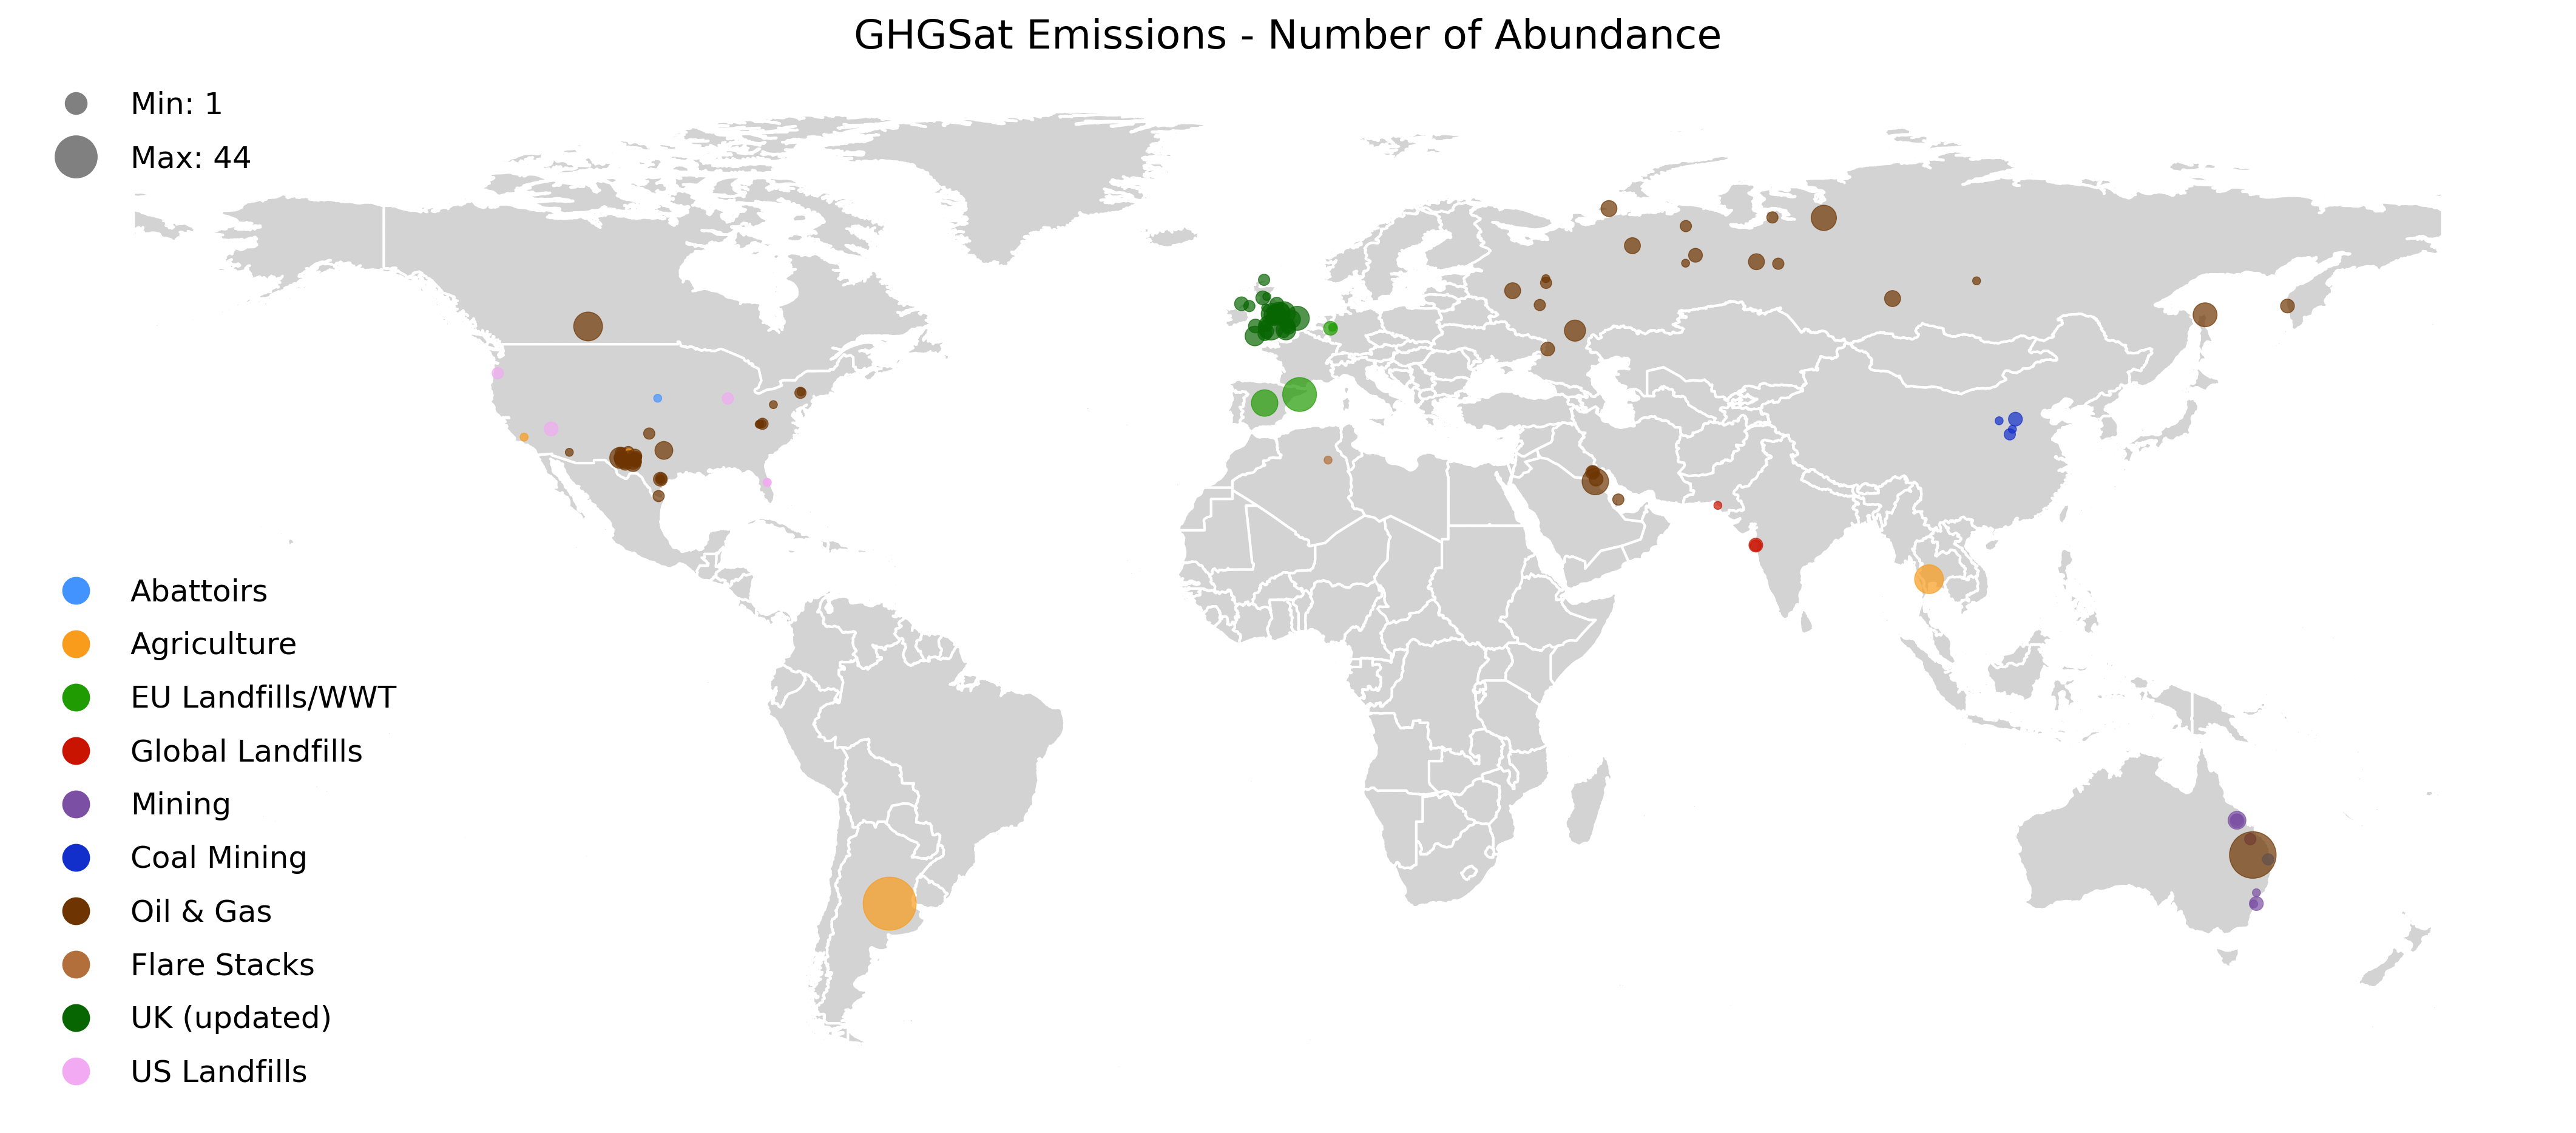

In [174]:
# PLot Number of Abundance products
globalPlot(dfAbs, 'GHGSat Emissions - Number of Abundance', leg, dfAbs['n_imgs']*10, True, False,'n_imgs' )

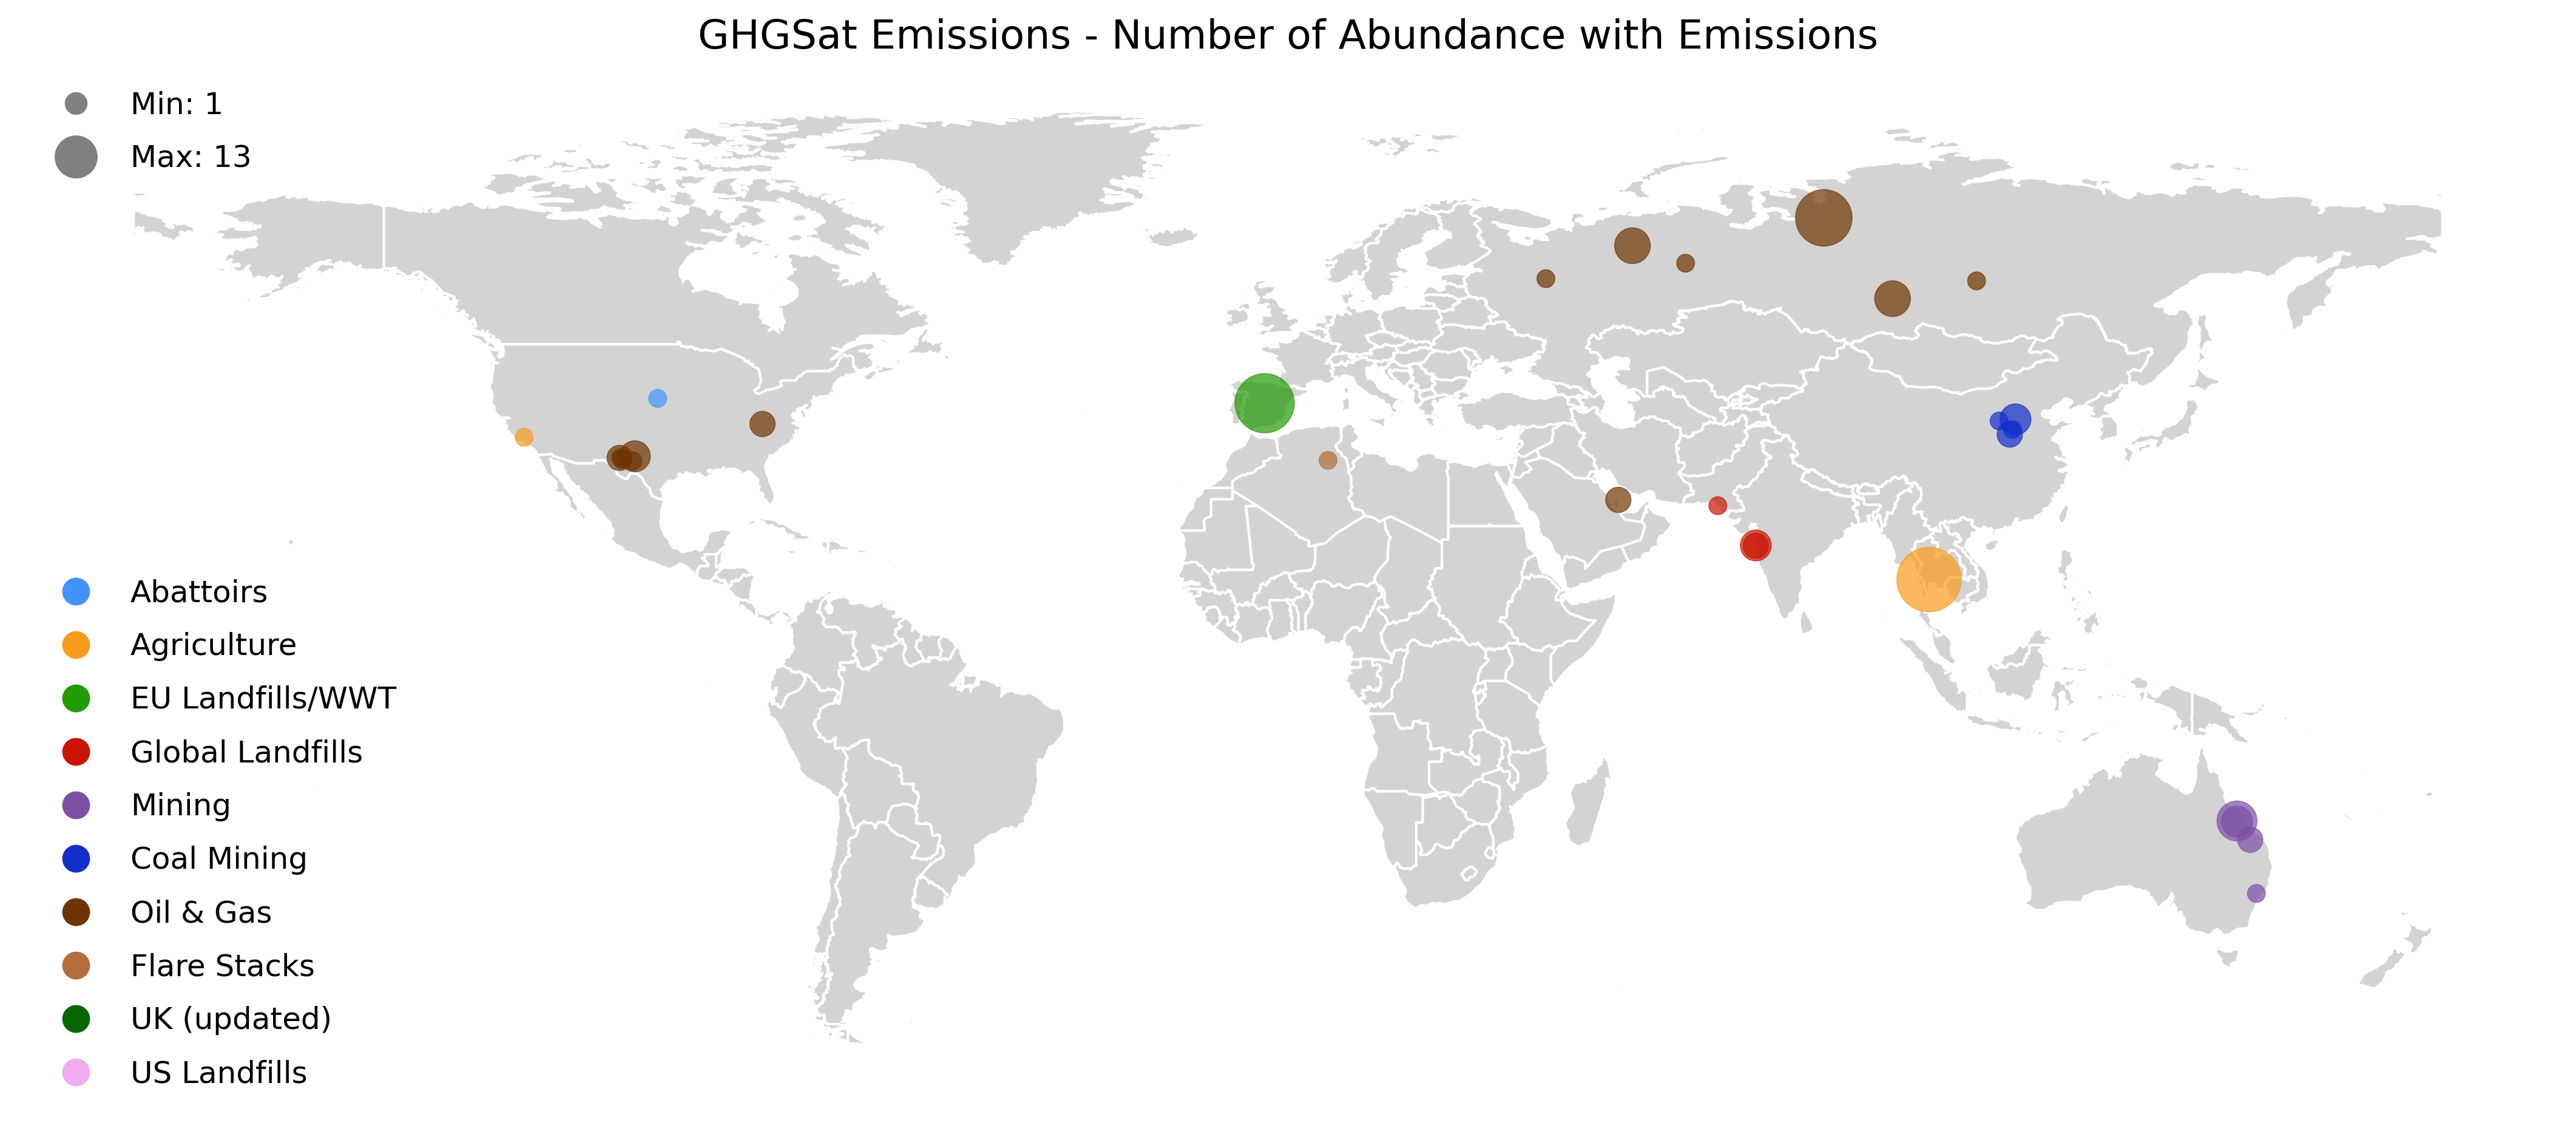

In [181]:
# PLot Number of Abundance products
data = dfAbs[dfAbs.success_fr>0]
globalPlot(data, 'GHGSat Emissions - Number of Abundance with Emissions', leg, data['n_imgs']*50, True, False,'n_imgs' )

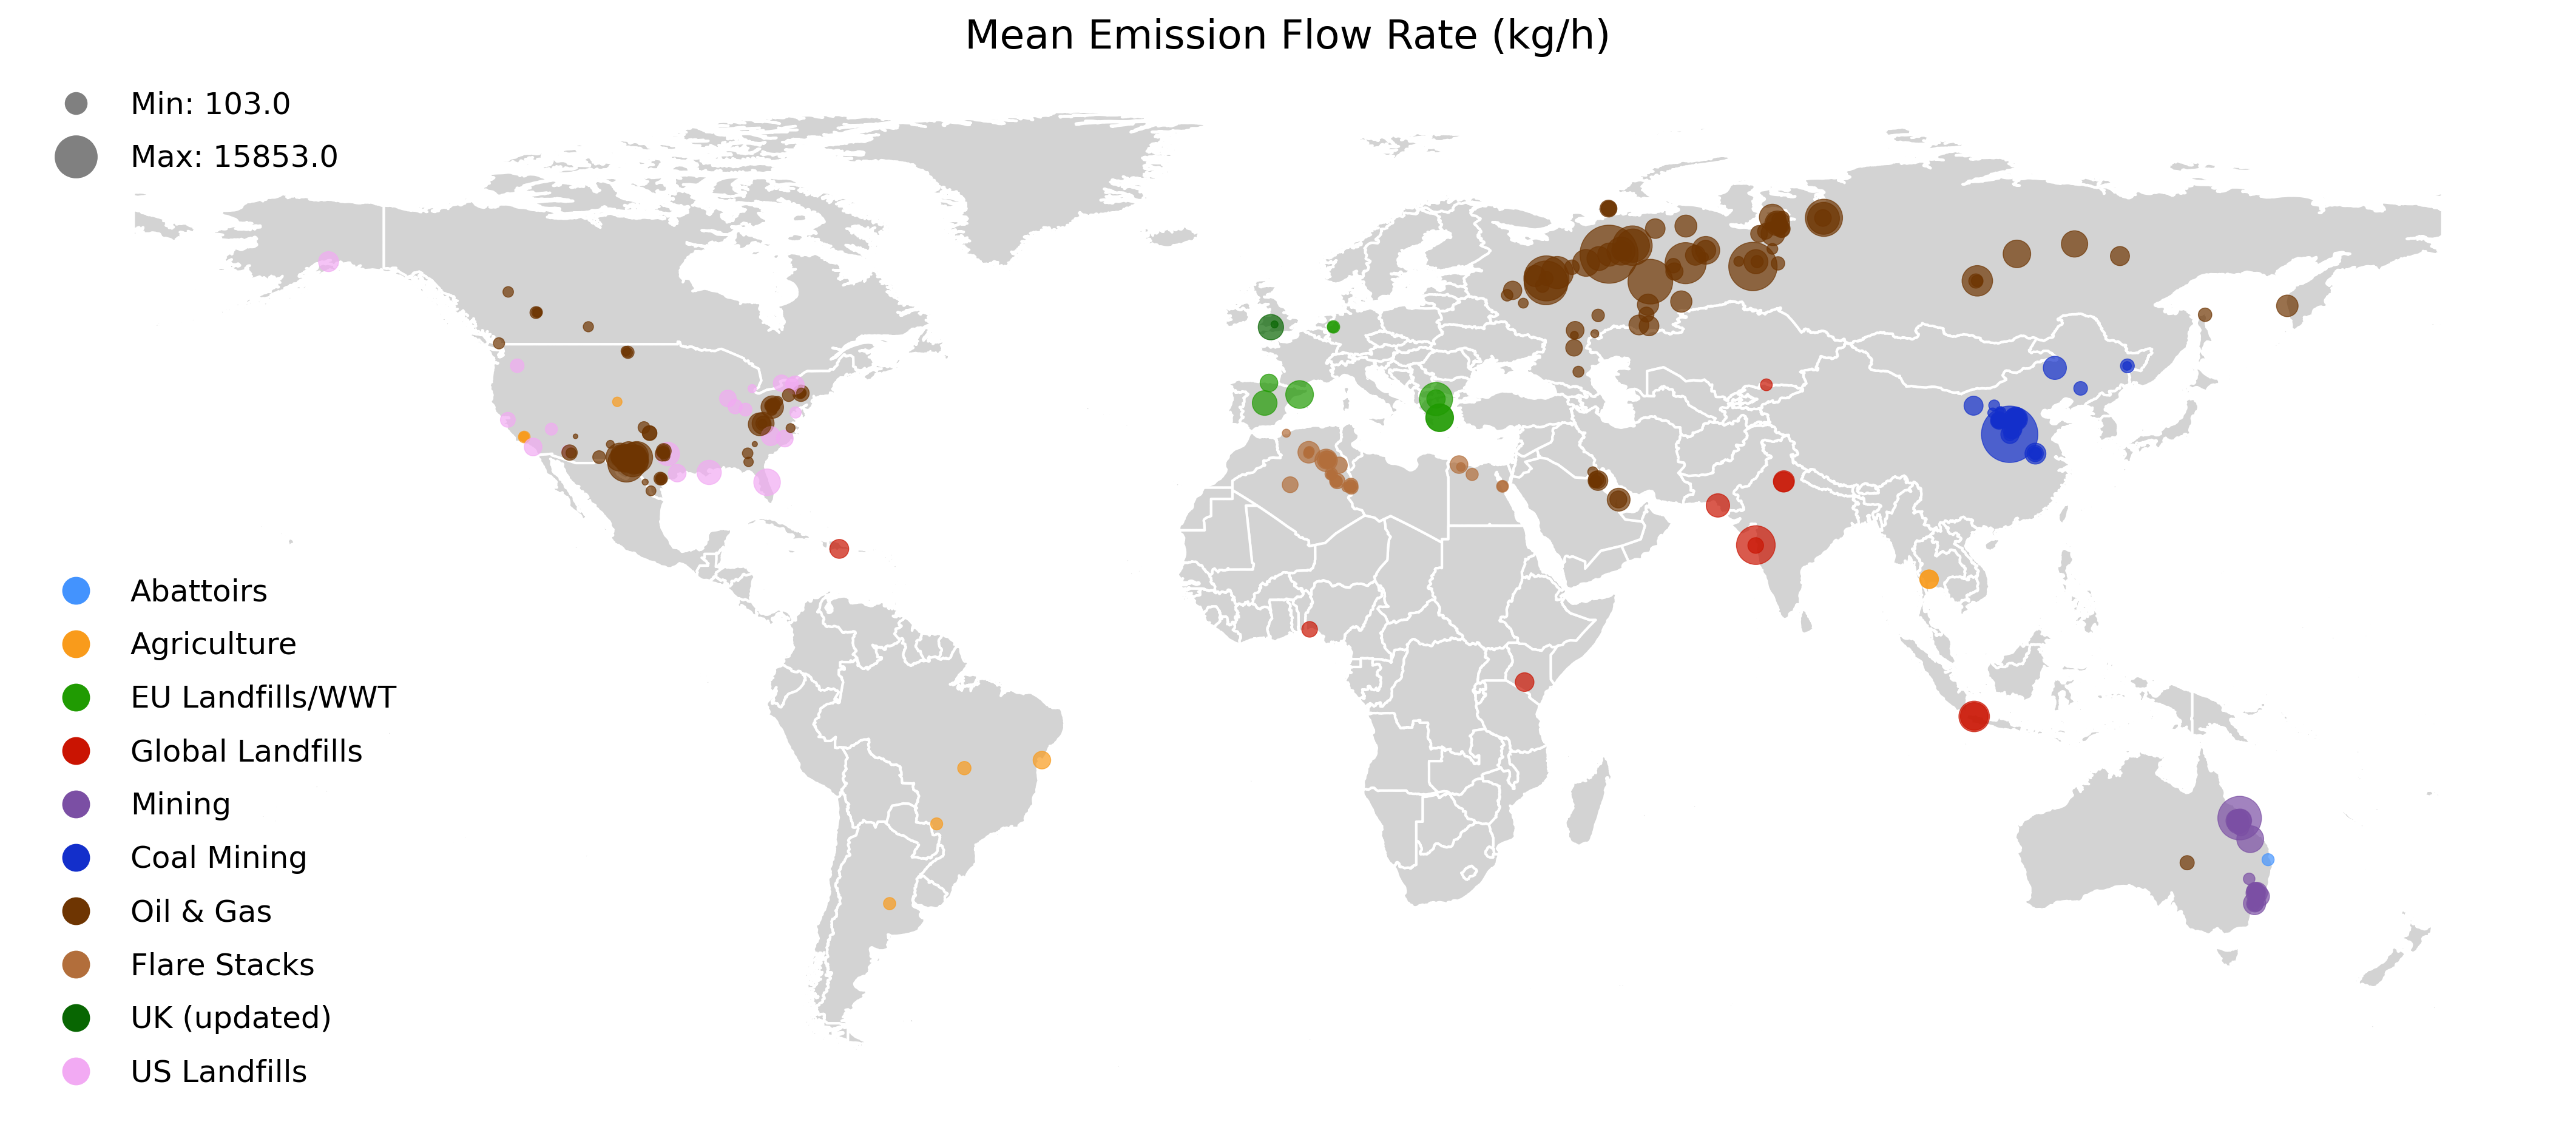

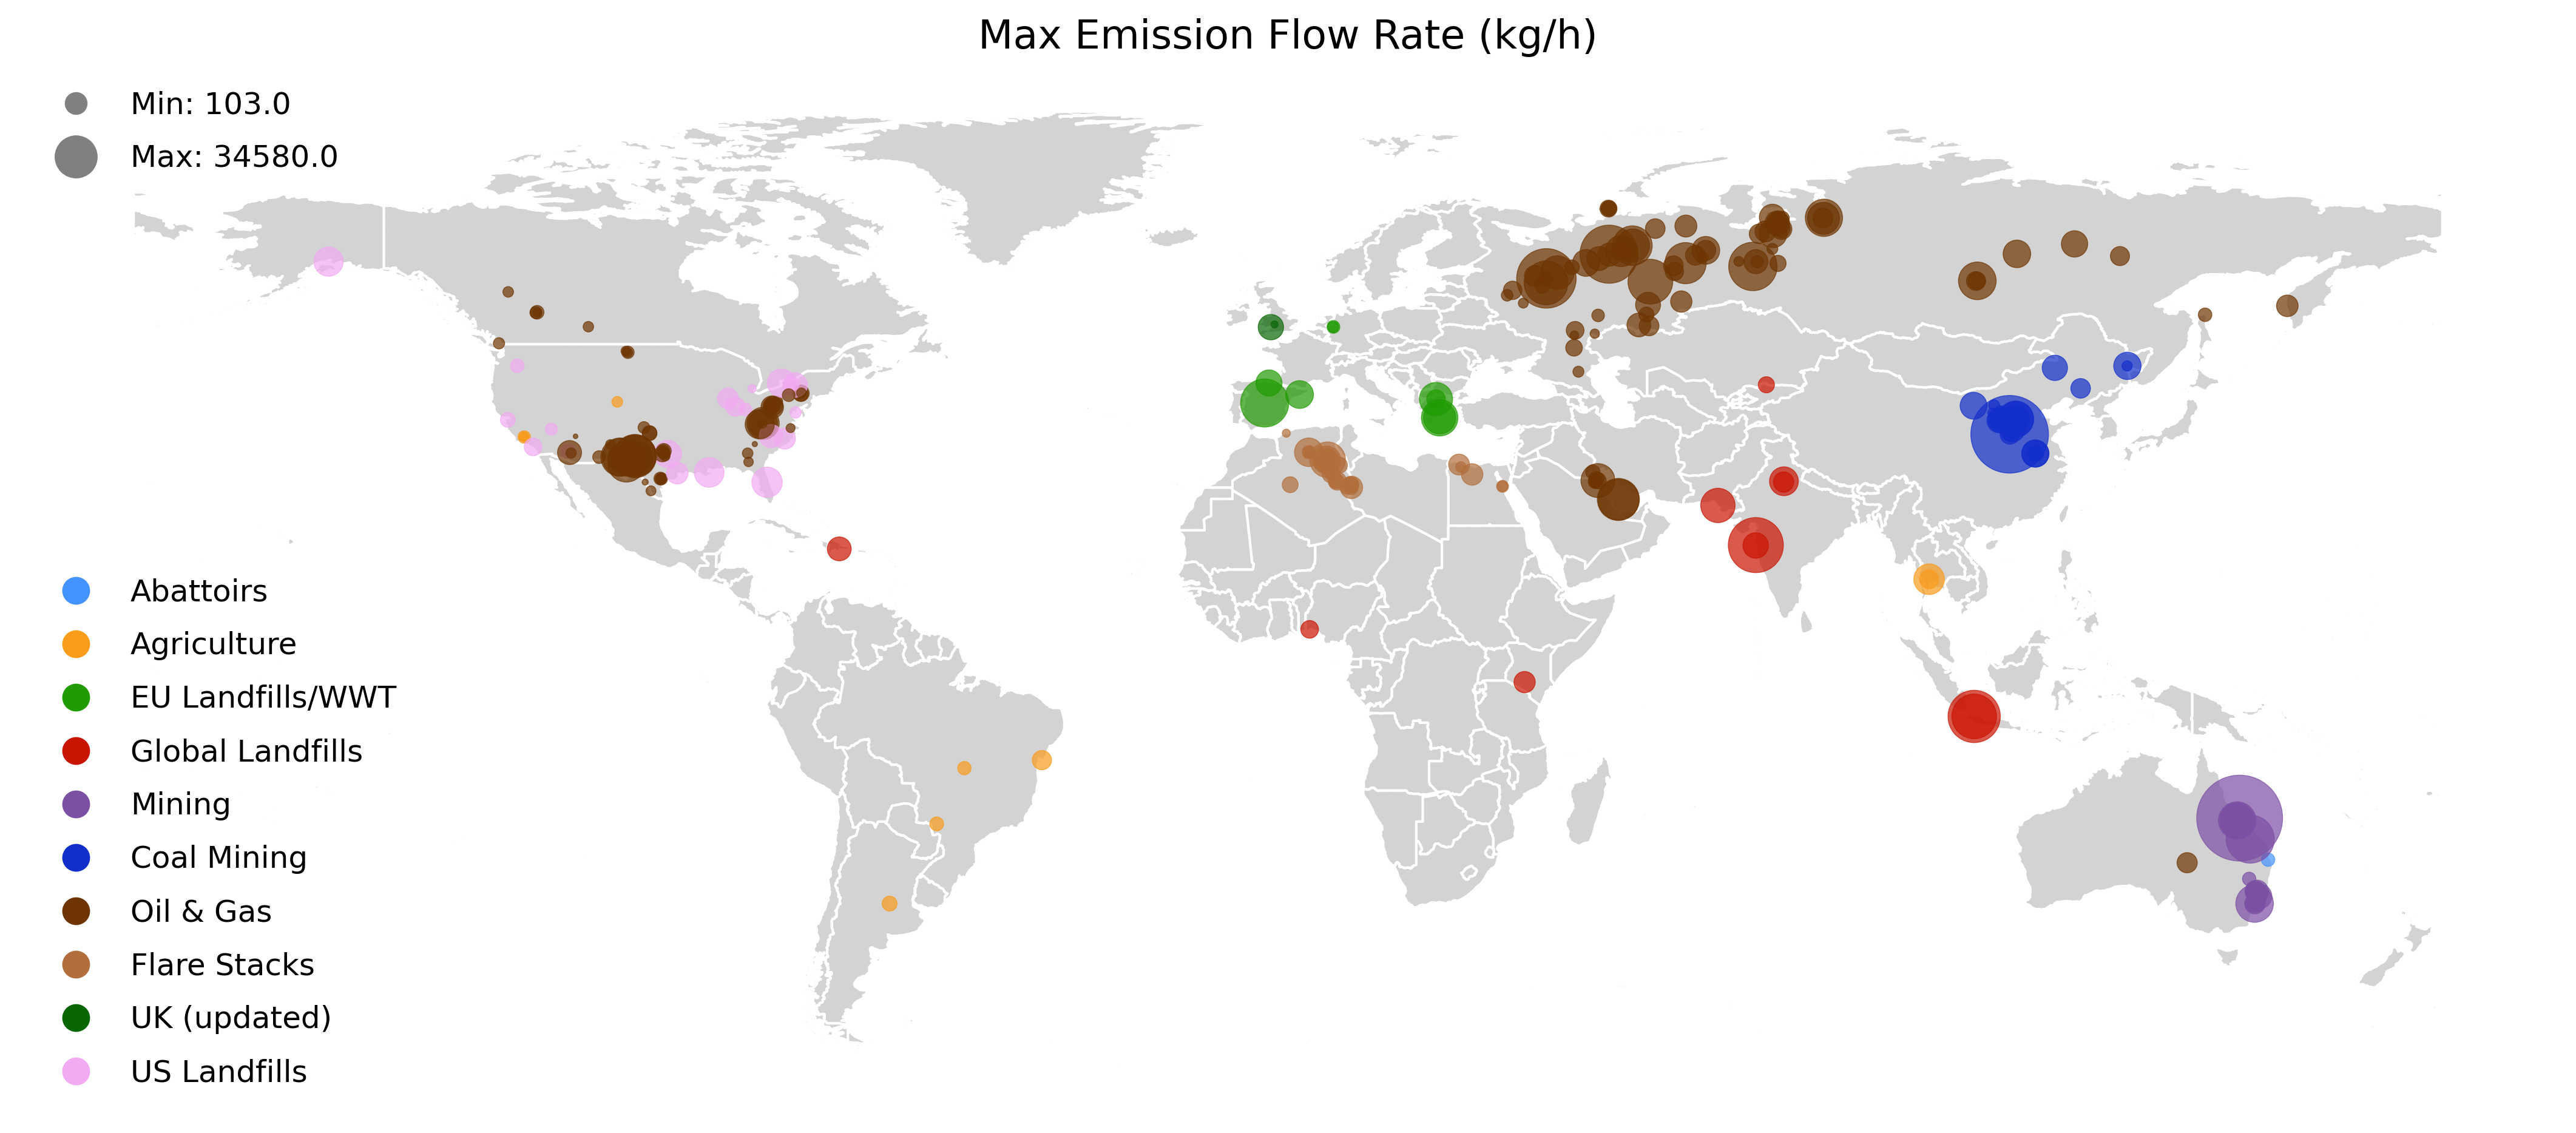

In [228]:
# PLot just the locations with number of images
globalPlot(dfEms, 'Mean Emission Flow Rate (kg/h)', leg, dfEms['meanRate']/30, True, False,'meanRate' )

# PLot just the locations with number of images
globalPlot(dfEms, 'Max Emission Flow Rate (kg/h)', leg, dfEms['maxRate']/30, True, False,'maxRate' )

In [227]:
for sector in dfAbs.group.unique():
    data = dfAbs[dfAbs.group == sector]
    top = data[data.n_imgs == data.n_imgs.max()]
    print('Sector ', sector )
    print('Country: ', top.cntry_name[0:1].item())
    print('Lat', top.lat[0:1].item())
    print('lon', top.lon[0:1].item())
    print('no of images', top.n_imgs[0:1].item())
    print('==============================================')

Sector  Abattoirs
Country:  Australia
Lat -27.613446
lon 152.834245
no of images 2
Sector  Mining
Country:  Australia
Lat -21.8026
lon 147.98
no of images 5
Sector  Oil_&_Gas
Country:  Australia
Lat -26.9627
lon 150.445
no of images 34
Sector  Agriculture
Country:  Argentina
Lat -34.1959
lon -62.1147
no of images 44
Sector  EU_Landfills/WWT
Country:  Spain
Lat 41.526458
lon 1.807049
no of images 18
Sector  UK (updated)
Country:  United Kingdom
Lat 51.512392
lon -2.674989
no of images 10
Sector  US_Landfills
Country:  United States
Lat 36.418892
lon -114.89434
no of images 3
Sector  Coal Mining
Country:  China
Lat 37.86
lon 113.43
no of images 3
Sector  Global_Landfills
Country:  India
Lat 19.13
lon 72.95
no of images 3
Sector  Flare Stacks
Country:  Algeria
Lat 31.7706
lon 6.2489
no of images 1


#### Emission flow time series

In [ ]:
def cumulative_sum(lst):
    cumulative_sum = 0
    return [cumulative_sum := cumulative_sum + num for num in lst]

sectors = [x for x in dfObs.sector2.unique() if x != 'UK']

fig, ax = plt.subplots(figsize=(7,3), dpi=300)

qurt_year_locator = mdates.MonthLocator(interval=3)
month_year_formatter = mdates.DateFormatter('%b, %Y') 
monthly_locator = mdates.MonthLocator()
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(qurt_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)

for sector in sectors:
    df, date, ems, obs = groupData(dfObs[dfObs.sector2 == sector])
    obsCuml = cumulative_sum(obs)
    emsCuml = cumulative_sum(ems)
    
#     ax.plot(date, eCuml,label=sector, color = colDict0[sector])
    ax.plot(date, obsCuml,label=sector, color = colDict0[sector])
    ax.plot(date, emsCuml, linestyle = '--', color = colDict0[sector])
    
#     ax.plot(date, eSum, label=sector, color = colDict0[sector])

ax.set_ylabel('Cumulative Frequency')
# ax.set_ylabel('Mean Emission Rate (kg/h)')
# Increase the timestamp by 15 days


ax.legend()
# 
fig.autofmt_xdate()

In [ ]:
sectors = [x for x in dfObs.sector2.unique() if x != 'UK']

fig, ax = plt.subplots(figsize=(7,3), dpi=300)

qurt_year_locator = mdates.MonthLocator(interval=3)
month_year_formatter = mdates.DateFormatter('%b, %Y') 
monthly_locator = mdates.MonthLocator()
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(qurt_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)

for sector in sectors:
    df, date, ems, obs = groupData(dfObs[dfObs.sector2 == sector])
    obsCuml = cumulative_sum(obs)
    emsCuml = cumulative_sum(ems)
    
#     ax.plot(date, eCuml,label=sector, color = colDict0[sector])
#     ax.plot(date, obs,label=sector, color = colDict0[sector])
    ax.plot(date, ems, linestyle = '--', color = colDict0[sector])
    
#     ax.plot(date, eSum, label=sector, color = colDict0[sector])

# ax.set_ylabel('Observations')
ax.set_ylabel('Emissions')
# Increase the timestamp by 15 days


# ax.legend()
# 
fig.autofmt_xdate()

C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_27340\2408794605.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.replace('_', ' ') for x in data.keys()], rotation = 90)


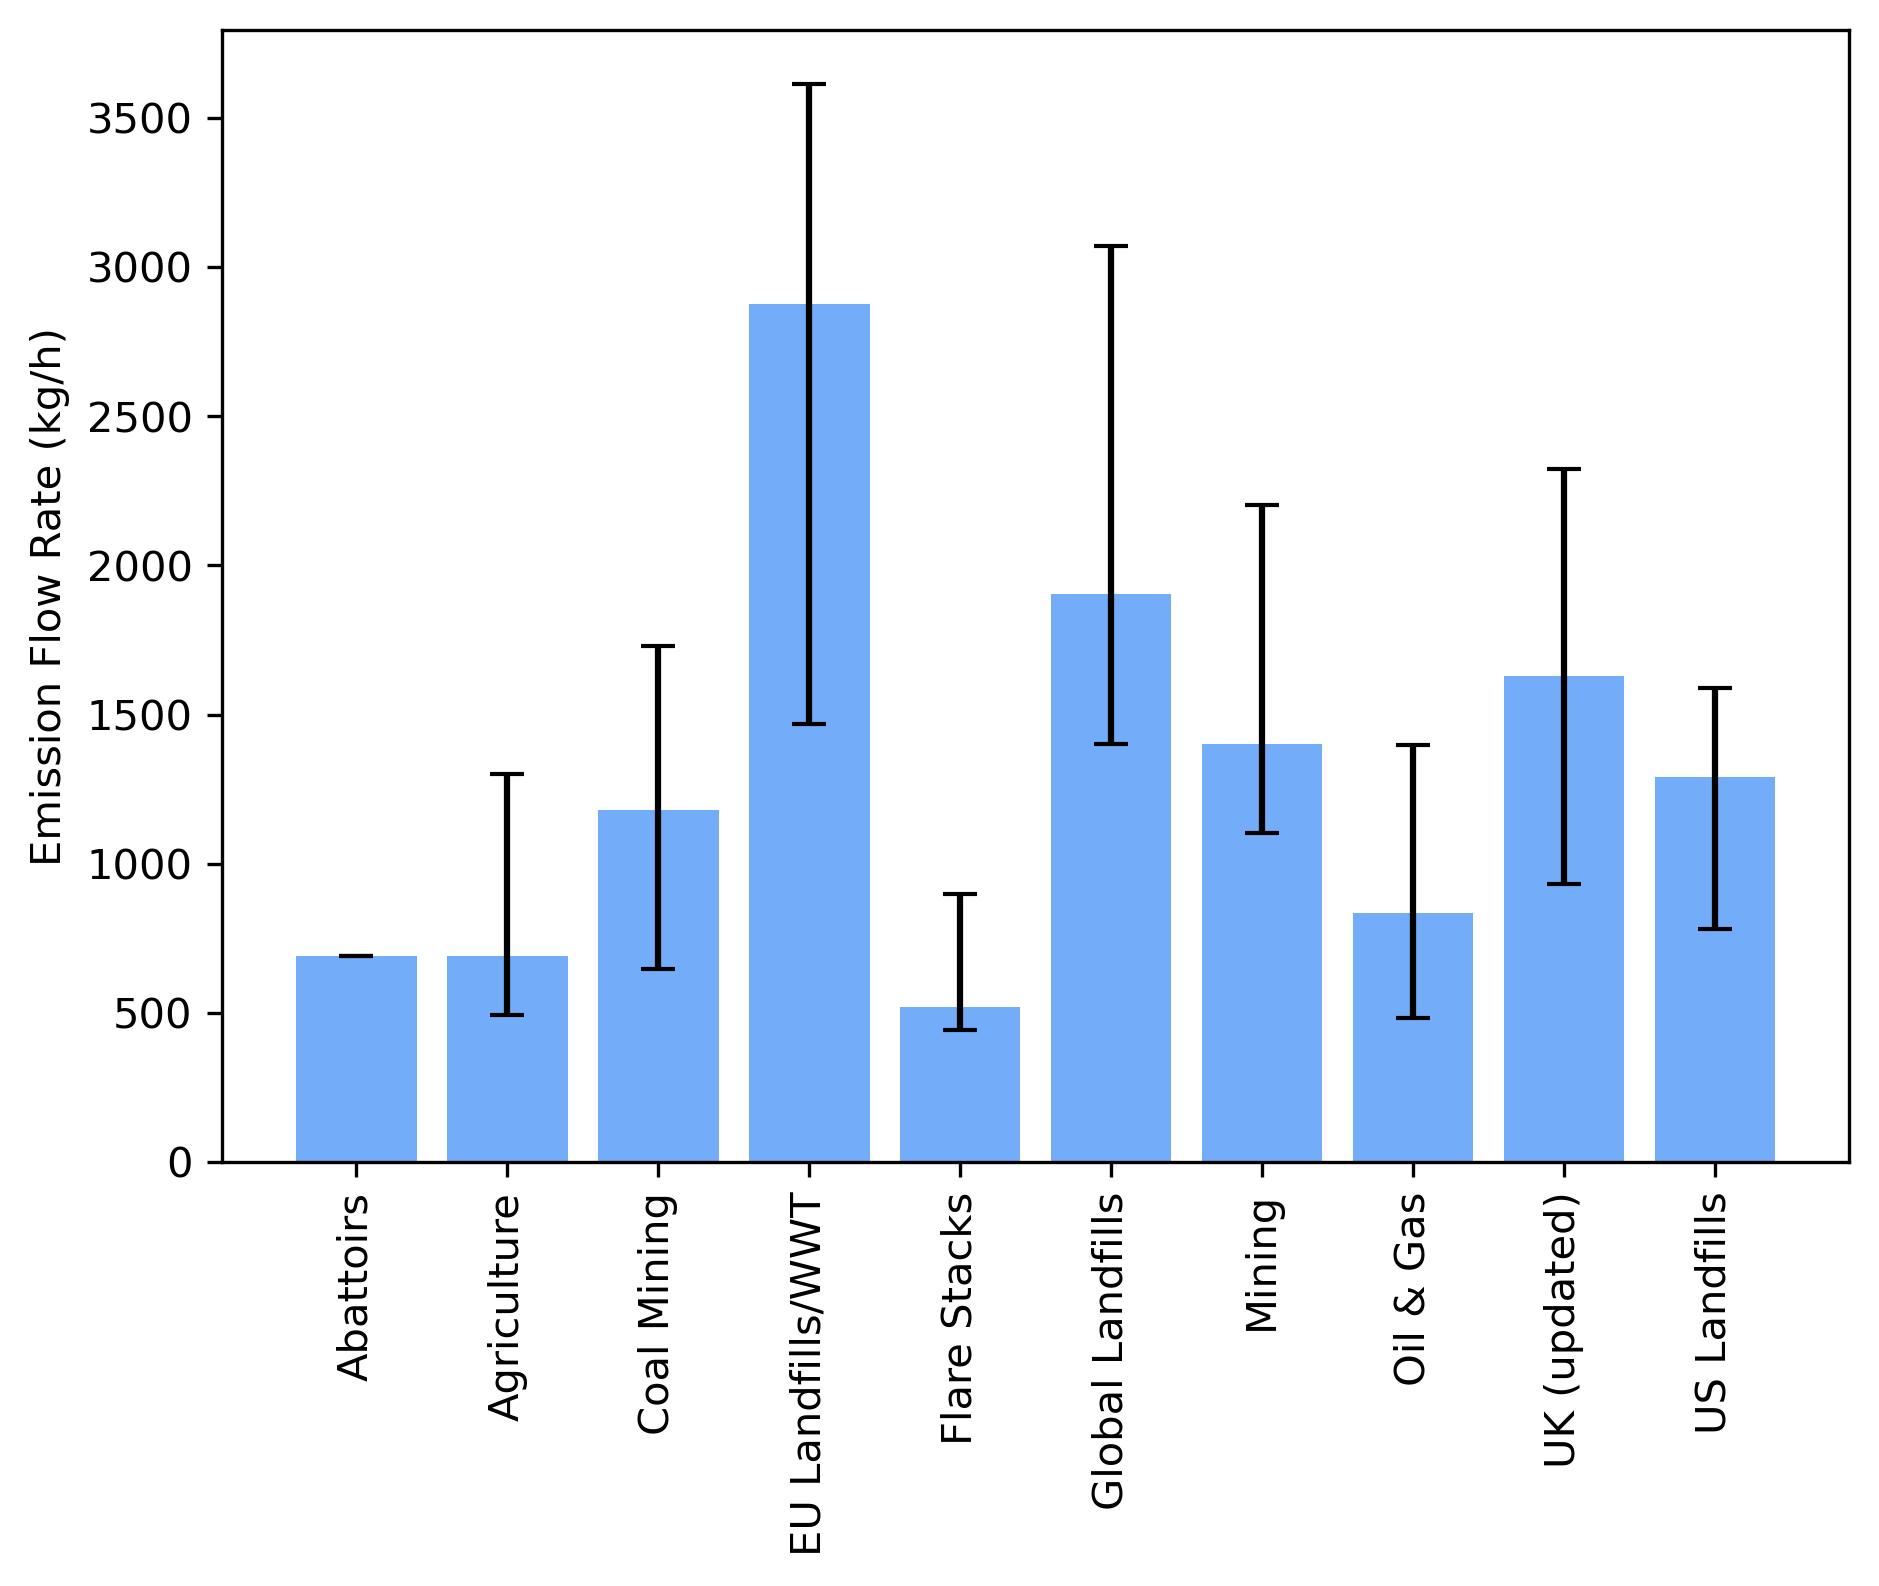

In [230]:
data = dfEms.groupby('group')['meanRate'].mean().to_dict()
# Calculate the percentiles for each category
medians = dfEms.groupby('group')['meanRate'].median()
q25 = dfEms.groupby('group')['meanRate'].apply(lambda x: np.nanpercentile(x, 25))
q75 = dfEms.groupby('group')['meanRate'].apply(lambda x: np.nanpercentile(x, 75))

fig, ax = plt.subplots(figsize=(7,5), dpi=300)
ax.bar(data.keys(), medians, yerr=[medians - q25, q75 - medians], color='#73ACF9', capsize=4)

# Set custom x-labels
ax.set_xticklabels([x.replace('_', ' ') for x in data.keys()], rotation = 90)
ax.set_ylabel('Emission Flow Rate (kg/h)')
plt.show()

In [231]:
table = dfEms.groupby('group')['meanRate'].std().reset_index(name='std')
table['median'] = [x for x in medians]
table['max'] = [x for x in dfEms.groupby('group')['maxRate'].max()]
table['count'] = [x for x in dfEms.groupby('group')['meanRate'].count()]
table['mean'] = [x for x in dfEms.groupby('group')['meanRate'].mean()]
# table.to_csv('Emission stats1.csv', index=False)

In [232]:
table

group          std  median      max  count         mean
0         Abattoirs          NaN   690.0    834.0      1   690.000000
1       Agriculture   495.758465   690.5   4399.0     10   878.700000
2       Coal Mining  2725.541332  1182.0  28268.0     27  1720.629630
3  EU_Landfills/WWT  1563.850678  2876.0  10838.0      9  2575.222222
4      Flare Stacks   512.280946   519.0   5973.0     38   734.552632
5  Global_Landfills  1855.361445  1905.0  14201.0     11  2534.090909
6            Mining  1586.792322  1403.0  34580.0     27  1817.481481
7         Oil_&_Gas  1847.526071   835.0  16609.0    254  1395.952756
8      UK (updated)  1969.292386  1628.5   3021.0      2  1628.500000
9      US_Landfills   777.342536  1289.5   4330.0     20  1369.050000

In [226]:
for sector in dfEms.group.unique():
    data = dfEms[dfEms.group == sector]
    top = data[data.n_imgs == data.n_imgs.max()]
    print('Sector ', sector )
    print('Country: ', top.cntry_name[0:1].item())
    print('Lat', top.lat[0:1].item())
    print('lon', top.lon[0:1].item())
    print('no of emission', top.n_imgs[0:1].item())
    print('==============================================')

Sector  EU_Landfills/WWT
Country:  Spain
Lat 40.263008
lon -3.635728
no of emission 82
Sector  Oil_&_Gas
Country:  United States
Lat 32.19538203
lon -104.10439655
no of emission 22
Sector  UK (updated)
Country:  United Kingdom
Lat 51.5399453
lon -2.66875851
no of emission 1
Sector  Flare Stacks
Country:  Egypt
Lat 29.63711859
lon 28.71422894
no of emission 27
Sector  Global_Landfills
Country:  India
Lat 28.621148
lon 77.328633
no of emission 60
Sector  Coal Mining
Country:  China
Lat 45.78261391
lon 130.88873035
no of emission 18
Sector  Agriculture
Country:  Thailand
Lat 14.05405725
lon 99.97280273
no of emission 40
Sector  US_Landfills
Country:  United States
Lat 43.21117803
lon -78.97386574
no of emission 16
Sector  Abattoirs
Country:  Australia
Lat -27.66259
lon 152.82818
no of emission 2
Sector  Mining
Country:  Australia
Lat -21.87767712
lon 148.02158552
no of emission 28


In [ ]:
for sector in dfAbs.sector.unique():
    data = dfAbs[dfAbs.sector == sector]
    
    print('Sector ', sector )
    print('Mean no of emission', round(data.success_fr.mean(),1))
    print('Mean no of obs', round(data.n_imgs.mean(),1))
    print('==============================================')

In [ ]:
dfAbs.groupby('group')['n_imgs'].sum()

In [ ]:
dfAbs.groupby('group')['coorid'].nunique()

#### Abundance data analysis

In [ ]:
legNull = [Line2D([0], [0], marker='o', color='w', label=x.replace('_', ' '), markerfacecolor=colDict[x], markersize=12) for x in colDict if x in dfAbs.group.unique()]

# PLot just the locations with number of images
globalPlot(dfAbs, 'GHGSat Abundance data - Number of Observations', legNull, dfAbs['n_imgs']*10, True, True,'n_imgs' )

#### Total number of images per sector

In [287]:
# Total number of images
print('Total number of images: ', pd.concat([AbGHG2.obsid, EmGHG2.obsid], axis = 0).reset_index().obsid.nunique())
print('Total number of Emissions: ', dfEms.success_fr.sum())
print('Total number of locations: ', dfEms.coorid.nunique())
print('Total number of abundance data: ', dfAbs.n_imgs.sum())
print('Total number of abundance data with emissions: ', AbGHG2[AbGHG2.success_fr > 0].obsid.nunique())

Total number of images:  1664
Total number of Emissions:  2051
Total number of locations:  424
Total number of abundance data:  503
Total number of abundance data with emissions:  60


In [288]:
AbGHG2[AbGHG2.success_fr > 0].obsid.nunique()
AbGHG2.obsid.nunique()

503

In [ ]:
sectorImgs = dfTot.groupby('group')['n_imgs'].sum().to_dict()
strings_with_spaces = [string.replace('_', ' ') for string in sectorImgs.keys()]

In [246]:
data = pd.concat([AbGHG2, EmGHG2], axis = 0)
data2 = data.groupby('obsid')['sector2'].unique().apply(lambda x: x[-1]).reset_index()
sectorImgs = data2.groupby('sector2')['obsid'].nunique().to_dict()
strings_with_spaces = [string.replace('_', ' ') for string in sectorImgs.keys()]

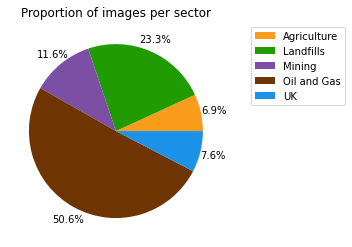

In [250]:
plt.pie(sectorImgs.values(),autopct='%1.1f%%', pctdistance=1.15, colors=[colDict0[x] for x in sectorImgs.keys()])#, labels=siteNumbers.values())
plt.title('Proportion of images per sector')
plt.legend(strings_with_spaces,bbox_to_anchor=(1.1, 1))

#### Total number of unique locations

Text(0.5, 1.0, 'Proportion of locations per sector')

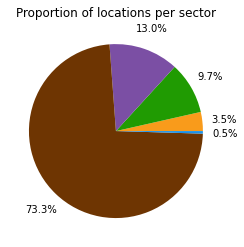

In [257]:
siteNumbers = dfEms.groupby('sector')['coorid'].nunique().to_dict()
# plt.pie(siteNumbers.values(), labels = siteNumbers.values(), colors=[colDict0[x] for x in siteNumbers.keys()])
plt.pie(siteNumbers.values(),autopct='%1.1f%%', pctdistance=1.25, colors=[colDict0[x] for x in siteNumbers.keys()])#, labels=siteNumbers.values())
plt.title('Proportion of locations per sector')
# plt.legend(strings_with_spaces,bbox_to_anchor=(1.1, 1))

#### Total number sites where emissions observed per sector

In [ ]:
pltData = dfTot.groupby('continent')['coorid'].count().to_dict()
plt.bar(pltData.keys(), pltData.values())
plt.xticks(rotation=45)
plt.ylabel('Number of Locations')

In [ ]:
pltData = dfTot.groupby('continent')['success_fr'].sum().to_dict()
plt.bar(pltData.keys(), pltData.values())
plt.xticks(rotation=45)
plt.ylabel('Number of Emissions')

#### Total number of emission observed per site per sector

Text(0.5, 1.0, 'Emission plumes per sector')

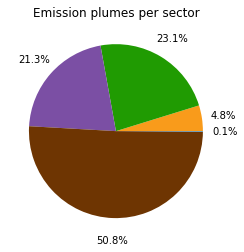

In [273]:
emisNum = dfEms.groupby('sector')['success_fr'].sum().to_dict()

# plt.pie(emisNum.values(), labels = emisNum.values(), colors=[colDict0[x] for x in siteNumbers.keys()])
plt.pie(emisNum.values(),autopct='%1.1f%%', pctdistance=1.25, colors=[colDict0[x] for x in siteNumbers.keys()])#, labels=siteNumbers.values())
plt.title('Emission plumes per sector')
# plt.legend(strings_with_spaces,bbox_to_anchor=(1.1, 1))

##### Total number of abundnace per sector

Text(0.5, 1.0, 'Abundance data per sector')

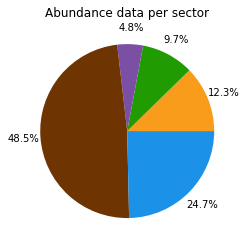

In [272]:
abunNum = dfAbs.groupby('sector')['n_imgs'].sum().to_dict()

# plt.pie(abunNum.values(), labels = abunNum.values(), colors=[colDict0[x] for x in siteNumbers.keys()])
plt.pie(abunNum.values(),autopct='%1.1f%%', pctdistance=1.2, colors=[colDict0[x] for x in siteNumbers.keys()])#, labels=siteNumbers.values())
plt.title('Abundance data per sector')
# plt.legend(strings_with_spaces,bbox_to_anchor=(1.1, 1))

In [269]:
dfAbs[dfAbs.sector == 'UK']

coorid  success_fr       lon        lat  n_imgs         group sector  \
96       97           0 -2.528430  53.500500       7  UK (updated)     UK   
97       98           0 -0.047551  51.827200       3  UK (updated)     UK   
98       99           0 -3.611500  50.578400       3  UK (updated)     UK   
99      100           0 -1.747990  54.958500       3  UK (updated)     UK   
100     101           0 -5.165350  50.227300       6  UK (updated)     UK   
101     102           0 -0.325662  51.102200       6  UK (updated)     UK   
102     103           0 -3.934360  55.901800       3  UK (updated)     UK   
103     104           0 -0.622938  53.644500       8  UK (updated)     UK   
104     105           0 -1.448820  53.769700       2  UK (updated)     UK   
105     106           0 -2.671090  53.374600       3  UK (updated)     UK   
106     107           0 -2.005870  52.683500       1  UK (updated)     UK   
107     108           0 -3.326240  50.916300       3  UK (updated)     UK   
108     109           0 -6.024480  54.679600       2  UK (updated)     UK   
109     110           0  1.458264  52.858674       9  UK (updated)     UK   
110     111           0  0.547887  52.715579       5  UK (updated)     UK   
111     112           0 -2.253186  53.011472       1  UK (updated)     UK   
112     113           0 -1.313258  53.697420       7  UK (updated)     UK   
113     114           0 -1.084112  53.857138       4  UK (updated)     UK   
114     115           0 -2.440185  53.910398       2  UK (updated)     UK   
115     116           0 -1.438929  53.571474       2  UK (updated)     UK   
116     117           0 -1.369115  53.549383       1  UK (updated)     UK   
117     118           0 -2.004567  53.960351       2  UK (updated)     UK   
118     119           0 -2.674989  51.512392      10  UK (updated)     UK   
119     120           0 -2.168212  52.968939       4  UK (updated)     UK   
120     121           0 -1.156170  53.616788       2  UK (updated)     UK   
121     122           0 -0.659565  50.821887       2  UK (updated)     UK   
122     123           0 -1.172518  53.426001       1  UK (updated)     UK   
123     124           0 -0.431288  53.283192       1  UK (updated)     UK   
124     125           0 -1.047264  53.551010       1  UK (updated)     UK   
125     126           0  0.081782  51.518961       3  UK (updated)     UK   
126     127           0 -7.252978  55.017099       3  UK (updated)     UK   
127     128           0 -3.644177  51.740630       2  UK (updated)     UK   
128     129           0 -2.130442  52.970389       1  UK (updated)     UK   
129     130           0 -5.076371  51.714945       3  UK (updated)     UK   
130     131           0 -3.331760  51.759700       2  UK (updated)     UK   
131     132           0 -3.730000  58.580000       2  UK (updated)     UK   
132     133           0 -1.232767  53.492488       1  UK (updated)     UK   
133     134           0 -3.490000  54.420000       1  UK (updated)     UK   
134     135           0 -3.307020  56.096400       1  UK (updated)     UK   
135     136           0 -0.744666  51.981900       1  UK (updated)     UK   

       color                   geometry continent      cntry_name  
96   #086602  POINT (-2.52843 53.50050)    Europe  United Kingdom  
97   #086602  POINT (-0.04755 51.82720)    Europe  United Kingdom  
98   #086602  POINT (-3.61150 50.57840)    Europe  United Kingdom  
99   #086602  POINT (-1.74799 54.95850)    Europe  United Kingdom  
100  #086602  POINT (-5.16535 50.22730)    Europe  United Kingdom  
101  #086602  POINT (-0.32566 51.10220)    Europe  United Kingdom  
102  #086602  POINT (-3.93436 55.90180)    Europe  United Kingdom  
103  #086602  POINT (-0.62294 53.64450)    Europe  United Kingdom  
104  #086602  POINT (-1.44882 53.76970)    Europe  United Kingdom  
105  #086602  POINT (-2.67109 53.37460)    Europe  United Kingdom  
106  #086602  POINT (-2.00587 52.68350)    Europe  United Kingdom  
107  #086602  POINT (-3.32624 5

In [ ]:
totNum = dfEms.groupby('group')['n_imgs'].sum().to_dict()

fig, ax = plt.subplots()
ax.pie(totNum.values(), labels = totNum.values(), colors=[colDict[x] for x in siteNumbers.keys()])

# Set the background color to white
fig.patch.set_facecolor('white')

plt.title('Total number of images per sector')
plt.legend(strings_with_spaces,bbox_to_anchor=(1.1, 1))